# Analysis of COVID-19 County Data from The New York Times

*Author: Mark Bauer*  
*Date: April 11, 2020*

The New York Times Github Data [Repository](https://github.com/nytimes/covid-19-data).   
The New York Time [News Article](https://www.nytimes.com/article/coronavirus-county-data-us.html).  
The New York Times COVID-19 US Map: https://www.nytimes.com/interactive/2020/us/coronavirus-us-cases.html.   
The New York Times COVID-19 Global Map: https://www.nytimes.com/interactive/2020/world/coronavirus-maps.html.

In [1]:
# importing libraries
import pandas as pd # the pd is by convention
import numpy as np # as is the np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.ticker import FuncFormatter
from matplotlib.dates import DateFormatter
import matplotlib.dates as dates
import seaborn as sns
import geopandas as gpd
import zipfile
from zipfile import ZipFile
from io import BytesIO
import os
import zipfile
from zipfile import ZipFile
from os.path import basename
import requests
import urllib
import squarify  

# to Plot matplotlib figures inline on the notebook
%matplotlib inline
sns.set(color_codes=True)

In [2]:
#Printing verions of Python modules and packages with **watermark** - the IPython magic extension.

%reload_ext watermark
%watermark -v -p numpy,pandas,matplotlib,matplotlib.pyplot,seaborn

CPython 3.7.1
IPython 7.2.0

numpy 1.16.1
pandas 1.0.0
matplotlib 3.0.2
matplotlib.pyplot 3.0.2
seaborn 0.9.0


In [3]:
url = 'https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv'

covid_19_counties_data = pd.read_csv(url)

In [4]:
covid_19_counties_data.head(10)

date       county       state     fips  cases  deaths
0  2020-01-21    Snohomish  Washington  53061.0      1       0
1  2020-01-22    Snohomish  Washington  53061.0      1       0
2  2020-01-23    Snohomish  Washington  53061.0      1       0
3  2020-01-24         Cook    Illinois  17031.0      1       0
4  2020-01-24    Snohomish  Washington  53061.0      1       0
5  2020-01-25       Orange  California   6059.0      1       0
6  2020-01-25         Cook    Illinois  17031.0      1       0
7  2020-01-25    Snohomish  Washington  53061.0      1       0
8  2020-01-26     Maricopa     Arizona   4013.0      1       0
9  2020-01-26  Los Angeles  California   6037.0      1       0

In [5]:
table = covid_19_counties_data.sort_values(by=['date', 'cases'], 
                                ascending=[False, False]).drop_duplicates(subset ="county", 
                                keep = 'first').reset_index(drop=True).head(10)

table['cases'] = table['cases'].map('{:,}'.format)
table['deaths'] = table['deaths'].map('{:,}'.format)
table.drop('fips', axis=1, inplace=True)
                 
print(table.to_markdown())

|    | date       | county        | state      | cases   | deaths   |
|---:|:-----------|:--------------|:-----------|:--------|:---------|
|  0 | 2020-04-17 | New York City | New York   | 127,352 | 8,632    |
|  1 | 2020-04-17 | Nassau        | New York   | 28,539  | 1,356    |
|  2 | 2020-04-17 | Suffolk       | New York   | 25,035  | 706      |
|  3 | 2020-04-17 | Westchester   | New York   | 22,476  | 738      |
|  4 | 2020-04-17 | Cook          | Illinois   | 19,391  | 760      |
|  5 | 2020-04-17 | Wayne         | Michigan   | 13,233  | 1,044    |
|  6 | 2020-04-17 | Bergen        | New Jersey | 11,863  | 714      |
|  7 | 2020-04-17 | Los Angeles   | California | 11,391  | 495      |
|  8 | 2020-04-17 | Essex         | New Jersey | 9,672   | 684      |
|  9 | 2020-04-17 | Hudson        | New Jersey | 9,636   | 420      |


In [6]:
covid_19_counties_data.shape

(67456, 6)

In [7]:
print('New York Times COVID-19 data as of', covid_19_counties_data.sort_values(by='date', 
                                   ascending=False)['date'].iloc[0])

New York Times COVID-19 data as of 2020-04-17


In [8]:
current_date = covid_19_counties_data.sort_values(by='date', ascending=False)['date'].iloc[0]

In [9]:
print('The current date of this notebook is', current_date)

The current date of this notebook is 2020-04-17


In [10]:
covid_19_counties_data.date = pd.to_datetime(covid_19_counties_data.date, infer_datetime_format=True)

In [11]:
covid_19_counties_data.dtypes

date      datetime64[ns]
county            object
state             object
fips             float64
cases              int64
deaths             int64
dtype: object

In [12]:
print(covid_19_counties_data['county'])

0         Snohomish
1         Snohomish
2         Snohomish
3              Cook
4         Snohomish
            ...    
67451      Sublette
67452    Sweetwater
67453         Teton
67454         Uinta
67455      Washakie
Name: county, Length: 67456, dtype: object


In [13]:
covid_19_counties_data['county_name'] = (covid_19_counties_data['county'] + ", " + covid_19_counties_data['state'])

In [14]:
covid_19_counties_data

date      county       state     fips  cases  deaths  \
0     2020-01-21   Snohomish  Washington  53061.0      1       0   
1     2020-01-22   Snohomish  Washington  53061.0      1       0   
2     2020-01-23   Snohomish  Washington  53061.0      1       0   
3     2020-01-24        Cook    Illinois  17031.0      1       0   
4     2020-01-24   Snohomish  Washington  53061.0      1       0   
...          ...         ...         ...      ...    ...     ...   
67451 2020-04-17    Sublette     Wyoming  56035.0      1       0   
67452 2020-04-17  Sweetwater     Wyoming  56037.0     10       0   
67453 2020-04-17       Teton     Wyoming  56039.0     61       0   
67454 2020-04-17       Uinta     Wyoming  56041.0      6       0   
67455 2020-04-17    Washakie     Wyoming  56043.0      4       0   

                 county_name  
0      Snohomish, Washington  
1      Snohomish, Washington  
2      Snohomish, Washington  
3             Cook, Illinois  
4      Snohomish, Washington  
...                      ...  
67451      Sublette, Wyoming  
67452    Sweetwater, Wyoming  
67453         Teton, Wyoming  
67454         Uinta, Wyoming  
67455      Washakie, Wyoming  

[67456 rows x 7 columns]

In [15]:
covid_19_counties_data.loc[covid_19_counties_data.county == 'Unknown']

date   county           state  fips  cases  deaths  \
418   2020-03-01  Unknown    Rhode Island   NaN      2       0   
450   2020-03-02  Unknown    Rhode Island   NaN      2       0   
485   2020-03-03  Unknown    Rhode Island   NaN      2       0   
522   2020-03-04  Unknown    Rhode Island   NaN      2       0   
569   2020-03-05  Unknown    Rhode Island   NaN      2       0   
...          ...      ...             ...   ...    ...     ...   
67136 2020-04-17  Unknown            Utah   NaN      2       1   
67152 2020-04-17  Unknown         Vermont   NaN     10       0   
67156 2020-04-17  Unknown  Virgin Islands   NaN     51       2   
67272 2020-04-17  Unknown        Virginia   NaN      0      94   
67316 2020-04-17  Unknown      Washington   NaN    174       0   

                   county_name  
418      Unknown, Rhode Island  
450      Unknown, Rhode Island  
485      Unknown, Rhode Island  
522      Unknown, Rhode Island  
569      Unknown, Rhode Island  
...                        ...  
67136            Unknown, Utah  
67152         Unknown, Vermont  
67156  Unknown, Virgin Islands  
67272        Unknown, Virginia  
67316      Unknown, Washington  

[794 rows x 7 columns]

In [16]:
print(len(covid_19_counties_data.loc[covid_19_counties_data.county == 'Unknown']))

794


In [17]:
covid_19_counties_data = covid_19_counties_data.loc[covid_19_counties_data.county != 'Unknown']

In [18]:
covid_19_counties_data.loc[covid_19_counties_data.county == 'Unknown']

Empty DataFrame
Columns: [date, county, state, fips, cases, deaths, county_name]
Index: []

# Begin Analysis

In [19]:
covid_19_counties_data.dtypes

date           datetime64[ns]
county                 object
state                  object
fips                  float64
cases                   int64
deaths                  int64
county_name            object
dtype: object

In [20]:
epi_curve = covid_19_counties_data.sort_values(by='date')

In [21]:
epi_curve = epi_curve.groupby(by='date')['cases'].sum().reset_index()

In [22]:
epi_curve['NewDate'] = epi_curve.date.dt.strftime("%m-%d")

In [23]:
epi_curve

date   cases NewDate
0  2020-01-21       1   01-21
1  2020-01-22       1   01-22
2  2020-01-23       1   01-23
3  2020-01-24       2   01-24
4  2020-01-25       3   01-25
..        ...     ...     ...
83 2020-04-13  573983   04-13
84 2020-04-14  600732   04-14
85 2020-04-15  630859   04-15
86 2020-04-16  662292   04-16
87 2020-04-17  693677   04-17

[88 rows x 3 columns]

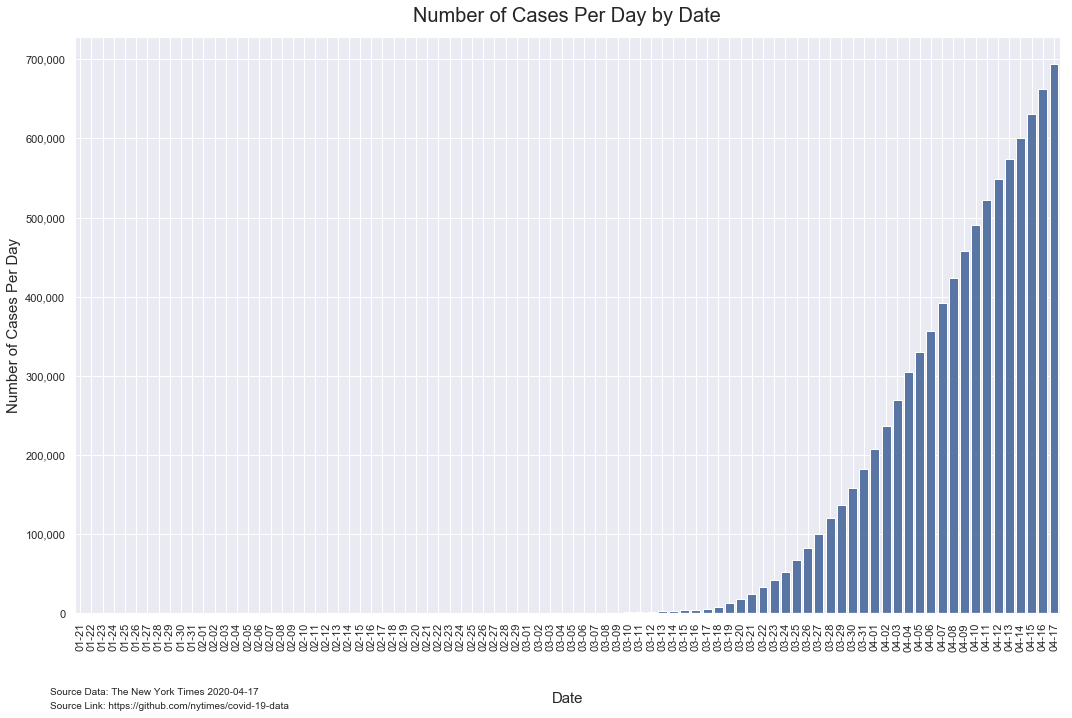

In [24]:
fig, ax1 = plt.subplots(figsize=(15,10))
txt = ('Source Data: The New York Times ' + current_date)
txt2 = ('Source Link: https://github.com/nytimes/covid-19-data')

sns.barplot(x="NewDate", 
            y="cases",
            color="C0",
            data=epi_curve)

ax1.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax1.xaxis.labelpad = 40

ax1.grid(True)
ax1.grid(axis='x', which='minor')
plt.xticks(rotation=90)

#ax1.legend_.remove()
ax1.set_xlabel('Date', fontsize=15)
ax1.set_ylabel('Number of Cases Per Day', fontsize=15)
plt.title('Number of Cases Per Day by Date', pad = 15, fontsize=20)
plt.figtext(0.05, 0.03, txt, wrap=True, horizontalalignment='left', fontsize=10)
plt.figtext(0.05, 0.01, txt2, wrap=True, horizontalalignment='left', fontsize=10)

plt.tight_layout()

In [25]:
epi_curve['3_day_rolling_average'] = epi_curve.cases.rolling(3).mean()

In [26]:
epi_curve

date   cases NewDate  3_day_rolling_average
0  2020-01-21       1   01-21                    NaN
1  2020-01-22       1   01-22                    NaN
2  2020-01-23       1   01-23               1.000000
3  2020-01-24       2   01-24               1.333333
4  2020-01-25       3   01-25               2.000000
..        ...     ...     ...                    ...
83 2020-04-13  573983   04-13          548125.333333
84 2020-04-14  600732   04-14          574418.000000
85 2020-04-15  630859   04-15          601858.000000
86 2020-04-16  662292   04-16          631294.333333
87 2020-04-17  693677   04-17          662276.000000

[88 rows x 4 columns]

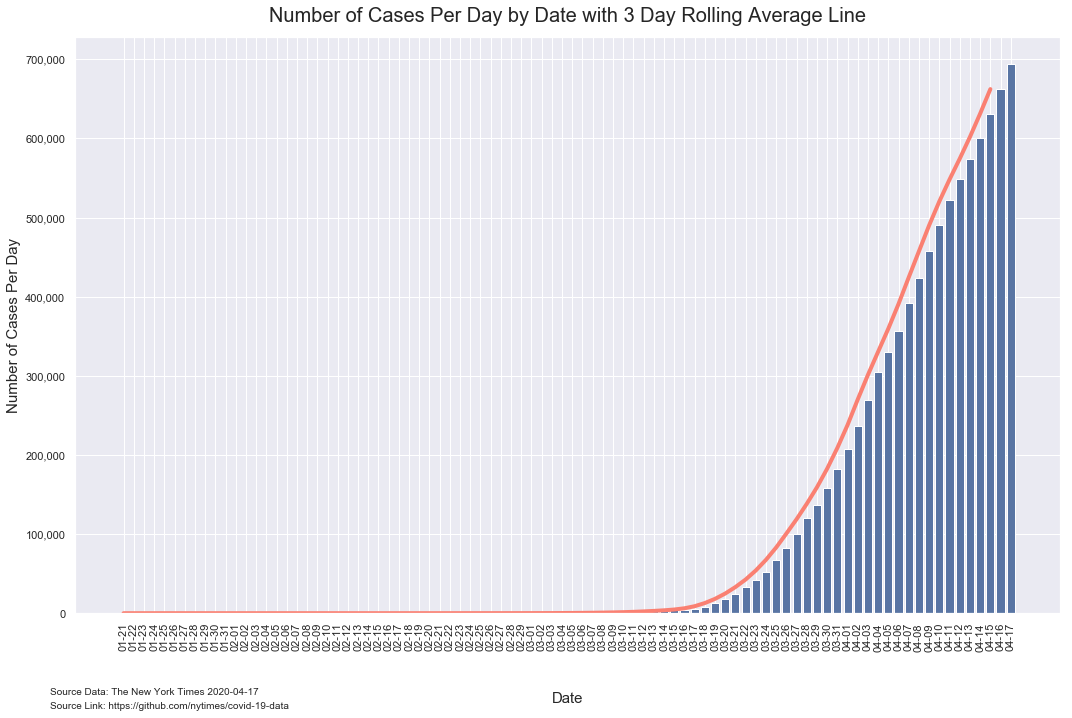

In [27]:
fig, ax1 = plt.subplots(figsize=(15,10))
txt = ('Source Data: The New York Times ' + current_date)
txt2 = ('Source Link: https://github.com/nytimes/covid-19-data')

sns.barplot(x="NewDate", 
            y="cases",
            color="C0",
            data=epi_curve)

sns.lineplot(x="NewDate", 
            y="3_day_rolling_average",
            color="salmon",
            data=epi_curve, linewidth=4)

ax1.xaxis.set_minor_locator(dates.WeekdayLocator(byweekday=(0), interval=1))
ax1.xaxis.set_minor_formatter(dates.DateFormatter('D'))
ax1.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax1.xaxis.labelpad = 40

ax1.grid(True)
ax1.grid(axis='x', which='minor')
plt.xticks(rotation=90)

ax1.set_xlabel('Date', fontsize=15)
ax1.set_ylabel('Number of Cases Per Day', fontsize=15)
plt.title('Number of Cases Per Day by Date with 3 Day Rolling Average Line', pad = 15, fontsize=20)
plt.figtext(0.05, 0.03, txt, wrap=True, horizontalalignment='left', fontsize=10)
plt.figtext(0.05, 0.01, txt2, wrap=True, horizontalalignment='left', fontsize=10)

plt.tight_layout()
plt.savefig('figures/epi_curve')

In [28]:
drop_duplicates = covid_19_counties_data.sort_values(by="cases", ascending=False).drop_duplicates(
                                                    subset ="county_name", keep = 'first')
top_10 = drop_duplicates[0:10]
top10_list = list(top_10.county_name)
top_10  = covid_19_counties_data.loc[covid_19_counties_data['county_name'].isin(top10_list)]

In [29]:
top_10

date         county       state     fips   cases  deaths  \
3     2020-01-24           Cook    Illinois  17031.0       1       0   
6     2020-01-25           Cook    Illinois  17031.0       1       0   
9     2020-01-26    Los Angeles  California   6037.0       1       0   
11    2020-01-26           Cook    Illinois  17031.0       1       0   
14    2020-01-27    Los Angeles  California   6037.0       1       0   
...          ...            ...         ...      ...     ...     ...   
66262 2020-04-17         Hudson  New Jersey  34017.0    9636     420   
66329 2020-04-17         Nassau    New York  36059.0   28539    1356   
66330 2020-04-17  New York City    New York      NaN  127352    8632   
66349 2020-04-17        Suffolk    New York  36103.0   25035     706   
66358 2020-04-17    Westchester    New York  36119.0   22476     738   

                   county_name  
3               Cook, Illinois  
6               Cook, Illinois  
9      Los Angeles, California  
11              Cook, Illinois  
14     Los Angeles, California  
...                        ...  
66262       Hudson, New Jersey  
66329         Nassau, New York  
66330  New York City, New York  
66349        Suffolk, New York  
66358    Westchester, New York  

[507 rows x 7 columns]

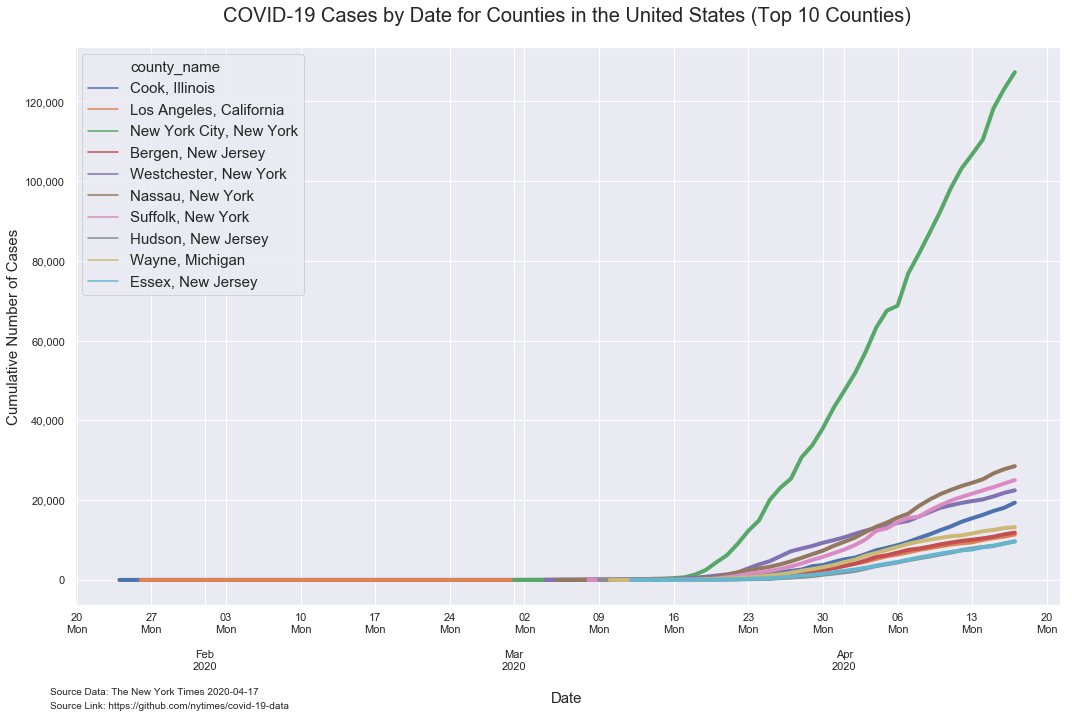

In [30]:
fig, ax1 = plt.subplots(figsize=(15,10))
txt = ('Source Data: The New York Times ' + current_date)
txt2 = ('Source Link: https://github.com/nytimes/covid-19-data')

sns.lineplot(x="date", y="cases",
             hue="county_name",
             data=top_10, linewidth=4, ci=False)

ax1.xaxis.set_minor_locator(dates.WeekdayLocator(byweekday=(0), interval=1))
ax1.xaxis.set_minor_formatter(dates.DateFormatter('%d\n%a'))
ax1.xaxis.grid(True, which="major")
ax1.xaxis.set_major_locator(dates.MonthLocator())
ax1.xaxis.set_major_formatter(dates.DateFormatter('\n\n\n%b\n%Y'))
ax1.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax1.xaxis.labelpad = 20

ax1.grid(True)
ax1.grid(axis='x', which='minor')

ax1.legend(fontsize=15)
ax1.set_xlabel('Date', fontsize=15)
ax1.set_ylabel('Cumulative Number of Cases', fontsize=15)
plt.title('COVID-19 Cases by Date for Counties in the United States (Top 10 Counties)', pad = 25, fontsize=20)
plt.figtext(0.05, 0.03, txt, wrap=True, horizontalalignment='left', fontsize=10)
plt.figtext(0.05, 0.01, txt2, wrap=True, horizontalalignment='left', fontsize=10)

plt.tight_layout()
plt.savefig('figures/county-timeseries-top10')

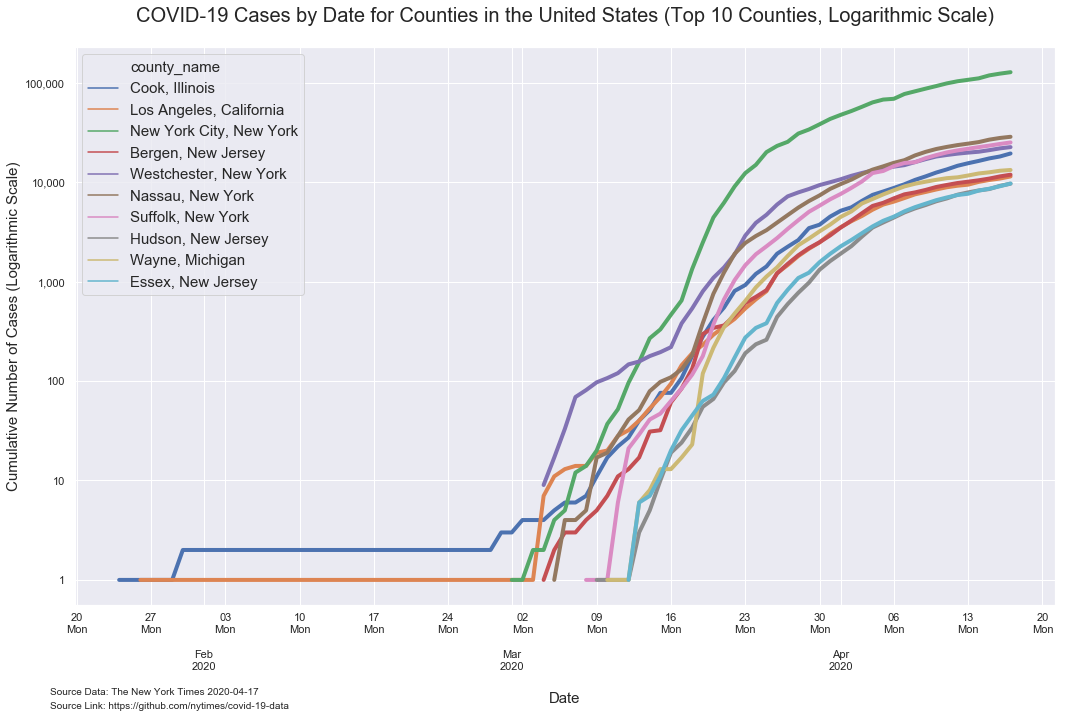

In [31]:
fig, ax1 = plt.subplots(figsize=(15,10))
txt = ('Source Data: The New York Times ' + current_date)
txt2 = ('Source Link: https://github.com/nytimes/covid-19-data')

sns.lineplot(x="date", y="cases",
             hue="county_name",
             data=top_10, linewidth=4, ci=False)

ax1.set_yscale('log')

ax1.xaxis.set_minor_locator(dates.WeekdayLocator(byweekday=(0), interval=1))
ax1.xaxis.set_minor_formatter(dates.DateFormatter('%d\n%a'))
ax1.xaxis.grid(True, which="major")
ax1.xaxis.set_major_locator(dates.MonthLocator())
ax1.xaxis.set_major_formatter(dates.DateFormatter('\n\n\n%b\n%Y'))
ax1.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax1.xaxis.labelpad = 20

ax1.grid(True)
ax1.grid(axis='x', which='minor')

ax1.legend(fontsize=15)
ax1.set_xlabel('Date', fontsize=15)
ax1.set_ylabel('Cumulative Number of Cases (Logarithmic Scale)', fontsize=15)
plt.title('COVID-19 Cases by Date for Counties in the United States (Top 10 Counties, Logarithmic Scale)', pad = 25, fontsize=20)
plt.figtext(0.05, 0.03, txt, wrap=True, horizontalalignment='left', fontsize=10)
plt.figtext(0.05, 0.01, txt2, wrap=True, horizontalalignment='left', fontsize=10)

plt.tight_layout()
plt.savefig('figures/county-timeseries-top10-log')

# Date to 10 Cases

In [32]:
county_ten_cases = top_10.loc[top_10.cases >= 10]

In [33]:
county_ten_cases = county_ten_cases.sort_values(by=['date', 'cases'], 
                                              ascending=[True, True]).drop_duplicates(subset ="county_name", 
                                                                                      keep = 'first').reset_index(drop=True)

In [34]:
county_ten_cases = county_ten_cases[['date', 'county_name']]
county_ten_cases.rename(columns={'date': 'date_ten_case'}, inplace=True)

In [35]:
county_ten_cases

date_ten_case              county_name
0    2020-03-05  Los Angeles, California
1    2020-03-05    Westchester, New York
2    2020-03-07  New York City, New York
3    2020-03-09           Cook, Illinois
4    2020-03-09         Nassau, New York
5    2020-03-11       Bergen, New Jersey
6    2020-03-12        Suffolk, New York
7    2020-03-15       Hudson, New Jersey
8    2020-03-15        Essex, New Jersey
9    2020-03-15          Wayne, Michigan

In [36]:
county_ten_cases = top_10.merge(county_ten_cases, left_on='county_name', right_on='county_name')

In [37]:
county_ten_cases

date county       state     fips  cases  deaths        county_name  \
0   2020-01-24   Cook    Illinois  17031.0      1       0     Cook, Illinois   
1   2020-01-25   Cook    Illinois  17031.0      1       0     Cook, Illinois   
2   2020-01-26   Cook    Illinois  17031.0      1       0     Cook, Illinois   
3   2020-01-27   Cook    Illinois  17031.0      1       0     Cook, Illinois   
4   2020-01-28   Cook    Illinois  17031.0      1       0     Cook, Illinois   
..         ...    ...         ...      ...    ...     ...                ...   
502 2020-04-13  Essex  New Jersey  34013.0   7634     433  Essex, New Jersey   
503 2020-04-14  Essex  New Jersey  34013.0   8212     535  Essex, New Jersey   
504 2020-04-15  Essex  New Jersey  34013.0   8579     590  Essex, New Jersey   
505 2020-04-16  Essex  New Jersey  34013.0   9084     642  Essex, New Jersey   
506 2020-04-17  Essex  New Jersey  34013.0   9672     684  Essex, New Jersey   

    date_ten_case  
0      2020-03-09  
1      2020-03-09  
2      2020-03-09  
3      2020-03-09  
4      2020-03-09  
..            ...  
502    2020-03-15  
503    2020-03-15  
504    2020-03-15  
505    2020-03-15  
506    2020-03-15  

[507 rows x 8 columns]

In [38]:
county_ten_cases = county_ten_cases.loc[county_ten_cases.cases >= 10]

In [39]:
county_ten_cases

date county       state     fips  cases  deaths        county_name  \
45  2020-03-09   Cook    Illinois  17031.0     11       0     Cook, Illinois   
46  2020-03-10   Cook    Illinois  17031.0     17       0     Cook, Illinois   
47  2020-03-11   Cook    Illinois  17031.0     22       0     Cook, Illinois   
48  2020-03-12   Cook    Illinois  17031.0     27       0     Cook, Illinois   
49  2020-03-13   Cook    Illinois  17031.0     40       0     Cook, Illinois   
..         ...    ...         ...      ...    ...     ...                ...   
502 2020-04-13  Essex  New Jersey  34013.0   7634     433  Essex, New Jersey   
503 2020-04-14  Essex  New Jersey  34013.0   8212     535  Essex, New Jersey   
504 2020-04-15  Essex  New Jersey  34013.0   8579     590  Essex, New Jersey   
505 2020-04-16  Essex  New Jersey  34013.0   9084     642  Essex, New Jersey   
506 2020-04-17  Essex  New Jersey  34013.0   9672     684  Essex, New Jersey   

    date_ten_case  
45     2020-03-09  
46     2020-03-09  
47     2020-03-09  
48     2020-03-09  
49     2020-03-09  
..            ...  
502    2020-03-15  
503    2020-03-15  
504    2020-03-15  
505    2020-03-15  
506    2020-03-15  

[387 rows x 8 columns]

In [40]:
county_ten_cases['days_since_ten_case'] = (county_ten_cases['date'] - 
                                      county_ten_cases['date_ten_case']).dt.days

/Users/geribauer/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [41]:
county_ten_cases

date county       state     fips  cases  deaths        county_name  \
45  2020-03-09   Cook    Illinois  17031.0     11       0     Cook, Illinois   
46  2020-03-10   Cook    Illinois  17031.0     17       0     Cook, Illinois   
47  2020-03-11   Cook    Illinois  17031.0     22       0     Cook, Illinois   
48  2020-03-12   Cook    Illinois  17031.0     27       0     Cook, Illinois   
49  2020-03-13   Cook    Illinois  17031.0     40       0     Cook, Illinois   
..         ...    ...         ...      ...    ...     ...                ...   
502 2020-04-13  Essex  New Jersey  34013.0   7634     433  Essex, New Jersey   
503 2020-04-14  Essex  New Jersey  34013.0   8212     535  Essex, New Jersey   
504 2020-04-15  Essex  New Jersey  34013.0   8579     590  Essex, New Jersey   
505 2020-04-16  Essex  New Jersey  34013.0   9084     642  Essex, New Jersey   
506 2020-04-17  Essex  New Jersey  34013.0   9672     684  Essex, New Jersey   

    date_ten_case  days_since_ten_case  
45     2020-03-09                    0  
46     2020-03-09                    1  
47     2020-03-09                    2  
48     2020-03-09                    3  
49     2020-03-09                    4  
..            ...                  ...  
502    2020-03-15                   29  
503    2020-03-15                   30  
504    2020-03-15                   31  
505    2020-03-15                   32  
506    2020-03-15                   33  

[387 rows x 9 columns]

# Daily Number of Cases Since 10th Case

In [42]:
county_ten_cases['daily_cases'] = (county_ten_cases.cases -
                                county_ten_cases.cases.shift(1))

/Users/geribauer/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [43]:
county_ten_cases[:50]

date       county       state     fips  cases  deaths  \
45  2020-03-09         Cook    Illinois  17031.0     11       0   
46  2020-03-10         Cook    Illinois  17031.0     17       0   
47  2020-03-11         Cook    Illinois  17031.0     22       0   
48  2020-03-12         Cook    Illinois  17031.0     27       0   
49  2020-03-13         Cook    Illinois  17031.0     40       0   
50  2020-03-14         Cook    Illinois  17031.0     51       0   
51  2020-03-15         Cook    Illinois  17031.0     76       0   
52  2020-03-16         Cook    Illinois  17031.0     76       0   
53  2020-03-17         Cook    Illinois  17031.0    107       1   
54  2020-03-18         Cook    Illinois  17031.0    179       1   
55  2020-03-19         Cook    Illinois  17031.0    279       2   
56  2020-03-20         Cook    Illinois  17031.0    412       3   
57  2020-03-21         Cook    Illinois  17031.0    548       4   
58  2020-03-22         Cook    Illinois  17031.0    805       6   
59  2020-03-23         Cook    Illinois  17031.0    922       9   
60  2020-03-24         Cook    Illinois  17031.0   1194      12   
61  2020-03-25         Cook    Illinois  17031.0   1418      13   
62  2020-03-26         Cook    Illinois  17031.0   1904      18   
63  2020-03-27         Cook    Illinois  17031.0   2239      20   
64  2020-03-28         Cook    Illinois  17031.0   2613      28   
65  2020-03-29         Cook    Illinois  17031.0   3445      40   
66  2020-03-30         Cook    Illinois  17031.0   3727      44   
67  2020-03-31         Cook    Illinois  17031.0   4496      61   
68  2020-04-01         Cook    Illinois  17031.0   5152      95   
69  2020-04-02         Cook    Illinois  17031.0   5575     107   
70  2020-04-03         Cook    Illinois  17031.0   6473     141   
71  2020-04-04         Cook    Illinois  17031.0   7439     167   
72  2020-04-05         Cook    Illinois  17031.0   8043     186   
73  2020-04-06         Cook    Illinois  17031.0   8728     209   
74  2020-04-07         Cook    Illinois  17031.0   9509     249   
75  2020-04-08         Cook    Illinois  17031.0  10520     312   
76  2020-04-09         Cook    Illinois  17031.0  11415     351   
77  2020-04-10         Cook    Illinois  17031.0  12472     398   
78  2020-04-11         Cook    Illinois  17031.0  13417     453   
79  2020-04-12         Cook    Illinois  17031.0  14585     485   
80  2020-04-13         Cook    Illinois  17031.0  15474     543   
81  2020-04-14         Cook    Illinois  17031.0  16323     577   
82  2020-04-15         Cook    Illinois  17031.0  17306     630   
83  2020-04-16         Cook    Illinois  17031.0  18087     722   
84  2020-04-17         Cook    Illinois  17031.0  19391     760   
124 2020-03-05  Los Angeles  California   6037.0     11       0   
125 2020-03-06  Los Angeles  California   6037.0     13       0   
126 2020-03-07  Los Angeles  California   6037.0     14       0   
127 2020-03-08  Los Angeles  California   6037.0     14       0   
128 2020-03-09  Los Angeles  California   6037.0     19       0   
129 2020-03-10  Los Angeles  California   6037.0     20       0   
130 2020-03-11  Los Angeles  California   6037.0     28       1   
131 2020-03-12  Los Angeles  California   6037.0     32       1   
132 2020-03-13  Los Angeles  California   6037.0     40       1   
133 2020-03-14  Los Angeles  California   6037.0     53       1   

                 county_name date_ten_case  days_since_ten_case  daily_cases  
45            Cook, Illinois    2020-03-09                    0          NaN  
46            Cook, Illinois    2020-03-09                    1          6.0  
47            Cook, Illinois    2020-03-09                    2          5.0  
48            Cook, Illinois    2020-03-09                    3          5.0  
49            Cook, Illinois    2020-03-09                    4         13.0  
50            Cook, Illinois    2020-03-09                    5         11.0  
51            Cook, Illinois    2020-03

In [44]:
county_ten_cases.columns

Index(['date', 'county', 'state', 'fips', 'cases', 'deaths', 'county_name',
       'date_ten_case', 'days_since_ten_case', 'daily_cases'],
      dtype='object')

In [45]:
county_ten_cases = county_ten_cases[['date', 'county', 'county_name', 'cases',  
                                   'daily_cases', 'deaths', 'date_ten_case','days_since_ten_case']]

In [46]:
county_ten_cases[250:300]

date   county         county_name  cases  daily_cases  deaths  \
356 2020-03-14  Suffolk   Suffolk, New York     41         12.0       0   
357 2020-03-15  Suffolk   Suffolk, New York     47          6.0       0   
358 2020-03-16  Suffolk   Suffolk, New York     63         16.0       2   
359 2020-03-17  Suffolk   Suffolk, New York     84         21.0       3   
360 2020-03-18  Suffolk   Suffolk, New York    116         32.0       3   
361 2020-03-19  Suffolk   Suffolk, New York    178         62.0       3   
362 2020-03-20  Suffolk   Suffolk, New York    371        193.0       7   
363 2020-03-21  Suffolk   Suffolk, New York    662        291.0       9   
364 2020-03-22  Suffolk   Suffolk, New York   1034        372.0      12   
365 2020-03-23  Suffolk   Suffolk, New York   1458        424.0      13   
366 2020-03-24  Suffolk   Suffolk, New York   1880        422.0      13   
367 2020-03-25  Suffolk   Suffolk, New York   2260        380.0      20   
368 2020-03-26  Suffolk   Suffolk, New York   2735        475.0      22   
369 2020-03-27  Suffolk   Suffolk, New York   3385        650.0      22   
370 2020-03-28  Suffolk   Suffolk, New York   4138        753.0      37   
371 2020-03-29  Suffolk   Suffolk, New York   5023        885.0      40   
372 2020-03-30  Suffolk   Suffolk, New York   5791        768.0      44   
373 2020-03-31  Suffolk   Suffolk, New York   6713        922.0      53   
374 2020-04-01  Suffolk   Suffolk, New York   7605        892.0      69   
375 2020-04-02  Suffolk   Suffolk, New York   8746       1141.0      84   
376 2020-04-03  Suffolk   Suffolk, New York  10154       1408.0      96   
377 2020-04-04  Suffolk   Suffolk, New York  12328       2174.0     175   
378 2020-04-05  Suffolk   Suffolk, New York  12933        605.0     175   
379 2020-04-06  Suffolk   Suffolk, New York  14473       1540.0     237   
380 2020-04-07  Suffolk   Suffolk, New York  15561       1088.0     266   
381 2020-04-08  Suffolk   Suffolk, New York  15844        283.0     328   
382 2020-04-09  Suffolk   Suffolk, New York  17413       1569.0     369   
383 2020-04-10  Suffolk   Suffolk, New York  18692       1279.0     425   
384 2020-04-11  Suffolk   Suffolk, New York  19883       1191.0     469   
385 2020-04-12  Suffolk   Suffolk, New York  20816        933.0     529   
386 2020-04-13  Suffolk   Suffolk, New York  21643        827.0     580   
387 2020-04-14  Suffolk   Suffolk, New York  22462        819.0     617   
388 2020-04-15  Suffolk   Suffolk, New York  23278        816.0     663   
389 2020-04-16  Suffolk   Suffolk, New York  24182        904.0     706   
390 2020-04-17  Suffolk   Suffolk, New York  25035        853.0     706   
397 2020-03-15   Hudson  Hudson, New Jersey     10     -25025.0       0   
398 2020-03-16   Hudson  Hudson, New Jersey     19          9.0       0   
399 2020-03-17   Hudson  Hudson, New Jersey     24          5.0       0   
400 2020-03-18   Hudson  Hudson, New Jersey     34         10.0       0   
401 2020-03-19   Hudson  Hudson, New Jersey     55         21.0       0   
402 2020-03-20   Hudson  Hudson, New Jersey     66         11.0       0   
403 2020-03-21   Hudson  Hudson, New Jersey     97         31.0       0   
404 2020-03-22   Hudson  Hudson, New Jersey    126         29.0       0   
405 2020-03-23   Hudson  Hudson, New Jersey    190         64.0       0   
406 2020-03-24   Hudson  Hudson, New Jersey    234         44.0       3   
407 2020-03-25   Hudson  Hudson, New Jersey    260         26.0       4   
408 2020-03-26   Hudson  Hudson, New Jersey    441        181.0       4   
409 2020-03-27   Hudson  Hudson, New Jersey    594        153.0       4   
410 2020-03-28   Hudson  Hudson, New Jersey    771        177.0       6   
411 2020-03-29   Hudson  Hudson, New Jersey    974        203.0       6   

    date_ten_case  days_since_ten_case  
356    2020-03-12                    2  
357    2020-03-12                    3  
358    2020-03-12                    4  
359    2020-03-12   

In [47]:
county_ten_cases['daily_cases'].loc[county_ten_cases.daily_cases < 0] = county_ten_cases['cases'] - 10

/Users/geribauer/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/Users/geribauer/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [48]:
county_ten_cases['daily_cases'].loc[county_ten_cases.daily_cases.isnull()] = county_ten_cases['cases'] - 10

/Users/geribauer/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [49]:
county_ten_cases[:50]

date       county              county_name  cases  daily_cases  \
45  2020-03-09         Cook           Cook, Illinois     11          1.0   
46  2020-03-10         Cook           Cook, Illinois     17          6.0   
47  2020-03-11         Cook           Cook, Illinois     22          5.0   
48  2020-03-12         Cook           Cook, Illinois     27          5.0   
49  2020-03-13         Cook           Cook, Illinois     40         13.0   
50  2020-03-14         Cook           Cook, Illinois     51         11.0   
51  2020-03-15         Cook           Cook, Illinois     76         25.0   
52  2020-03-16         Cook           Cook, Illinois     76          0.0   
53  2020-03-17         Cook           Cook, Illinois    107         31.0   
54  2020-03-18         Cook           Cook, Illinois    179         72.0   
55  2020-03-19         Cook           Cook, Illinois    279        100.0   
56  2020-03-20         Cook           Cook, Illinois    412        133.0   
57  2020-03-21         Cook           Cook, Illinois    548        136.0   
58  2020-03-22         Cook           Cook, Illinois    805        257.0   
59  2020-03-23         Cook           Cook, Illinois    922        117.0   
60  2020-03-24         Cook           Cook, Illinois   1194        272.0   
61  2020-03-25         Cook           Cook, Illinois   1418        224.0   
62  2020-03-26         Cook           Cook, Illinois   1904        486.0   
63  2020-03-27         Cook           Cook, Illinois   2239        335.0   
64  2020-03-28         Cook           Cook, Illinois   2613        374.0   
65  2020-03-29         Cook           Cook, Illinois   3445        832.0   
66  2020-03-30         Cook           Cook, Illinois   3727        282.0   
67  2020-03-31         Cook           Cook, Illinois   4496        769.0   
68  2020-04-01         Cook           Cook, Illinois   5152        656.0   
69  2020-04-02         Cook           Cook, Illinois   5575        423.0   
70  2020-04-03         Cook           Cook, Illinois   6473        898.0   
71  2020-04-04         Cook           Cook, Illinois   7439        966.0   
72  2020-04-05         Cook           Cook, Illinois   8043        604.0   
73  2020-04-06         Cook           Cook, Illinois   8728        685.0   
74  2020-04-07         Cook           Cook, Illinois   9509        781.0   
75  2020-04-08         Cook           Cook, Illinois  10520       1011.0   
76  2020-04-09         Cook           Cook, Illinois  11415        895.0   
77  2020-04-10         Cook           Cook, Illinois  12472       1057.0   
78  2020-04-11         Cook           Cook, Illinois  13417        945.0   
79  2020-04-12         Cook           Cook, Illinois  14585       1168.0   
80  2020-04-13         Cook           Cook, Illinois  15474        889.0   
81  2020-04-14         Cook           Cook, Illinois  16323        849.0   
82  2020-04-15         Cook           Cook, Illinois  17306        983.0   
83  2020-04-16         Cook           Cook, Illinois  18087        781.0   
84  2020-04-17         Cook           Cook, Illinois  19391       1304.0   
124 2020-03-05  Los Angeles  Los Angeles, California     11          1.0   
125 2020-03-06  Los Angeles  Los Angeles, California     13          2.0   
126 2020-03-07  Los Angeles  Los Angeles, California     14          1.0   
127 2020-03-08  Los Angeles  Los Angeles, California     14          0.0   
128 2020-03-09  Los Angeles  Los Angeles, California     19          5.0   
129 2020-03-10  Los Angeles  Los Angeles, California     20          1.0   
130 2020-03-11  Los Angeles  Los Angeles, California     28          8.0   
131 2020-03-12  Los Angeles  Los Angeles, California     32          4.0   
132 2020-03-13  Los Angeles  Los Angeles, California     40          8.0   
133 2020-03-14  Los Angeles  Los Angeles, California     53         13.0   

     deaths date_ten_case  days_since_ten_case  
45        0    2020-03-09                    0  
46        0    2020-03-09          

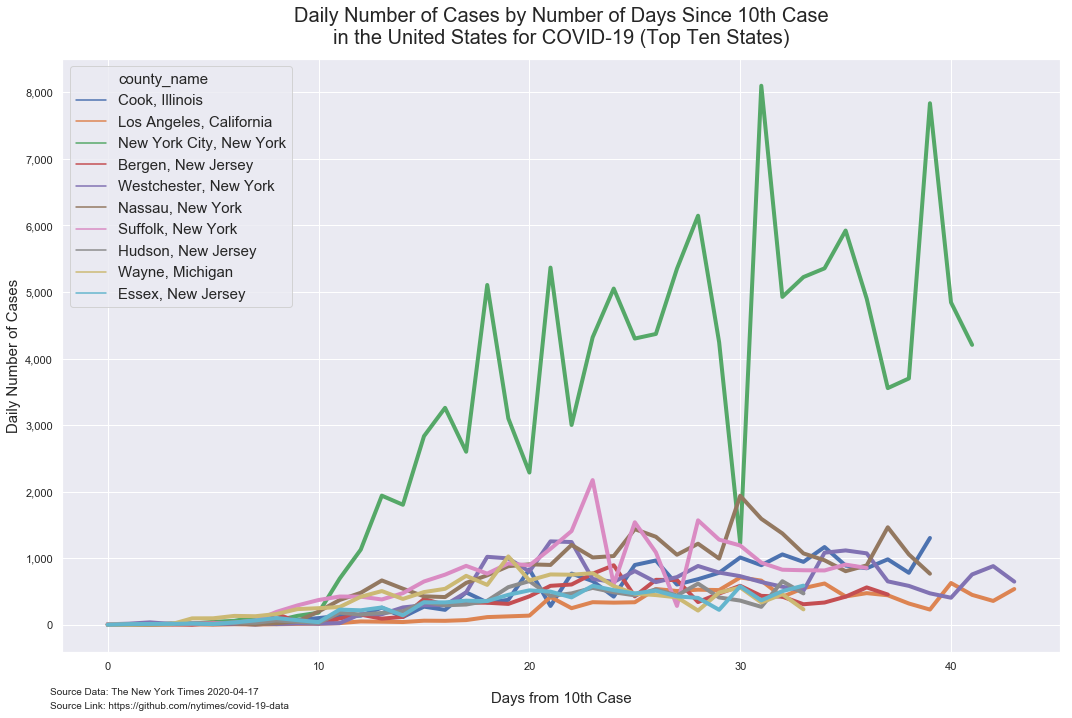

In [50]:
fig, ax1 = plt.subplots(figsize=(15,10))
txt = ('Source Data: The New York Times ' + current_date)
txt2 = ('Source Link: https://github.com/nytimes/covid-19-data')

sns.lineplot(x="days_since_ten_case", y="daily_cases",
             hue="county_name",
             data=county_ten_cases, linewidth=4)

ax1.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax1.xaxis.labelpad = 20

ax1.grid(True)
ax1.grid(axis='x', which='minor')

ax1.legend(loc='upper left', fontsize=15)
ax1.set_xlabel('Days from 10th Case', fontsize=15)
ax1.set_ylabel('Daily Number of Cases', fontsize=15)
plt.title('Daily Number of Cases by Number of Days Since 10th Case\nin the United States for COVID-19 (Top Ten States)', pad = 15, fontsize=20)
plt.figtext(0.05, 0.03, txt, wrap=True, horizontalalignment='left', fontsize=10)
plt.figtext(0.05, 0.01, txt2, wrap=True, horizontalalignment='left', fontsize=10)

plt.tight_layout()
plt.savefig('figures/10-cases-timeseries-by-county-top-10-daily')

In [51]:
county_ten_cases['daily_cases'].loc[county_ten_cases.daily_cases == 0]

52     0.0
127    0.0
397    0.0
437    0.0
Name: daily_cases, dtype: float64

In [52]:
temp_fill_zeros = county_ten_cases.sort_values(by=['county_name', 'date','cases'], 
                                                 ascending=[True, True, True])

temp_fill_zeros['daily_cases'].loc[temp_fill_zeros.daily_cases == 0] = 1

temp_fill_zeros

date       county            county_name  cases  daily_cases  \
223 2020-03-11       Bergen     Bergen, New Jersey     11          1.0   
224 2020-03-12       Bergen     Bergen, New Jersey     13          2.0   
225 2020-03-13       Bergen     Bergen, New Jersey     17          4.0   
226 2020-03-14       Bergen     Bergen, New Jersey     31         14.0   
227 2020-03-15       Bergen     Bergen, New Jersey     32          1.0   
..         ...          ...                    ...    ...          ...   
301 2020-04-13  Westchester  Westchester, New York  19785        472.0   
302 2020-04-14  Westchester  Westchester, New York  20191        406.0   
303 2020-04-15  Westchester  Westchester, New York  20947        756.0   
304 2020-04-16  Westchester  Westchester, New York  21828        881.0   
305 2020-04-17  Westchester  Westchester, New York  22476        648.0   

     deaths date_ten_case  days_since_ten_case  
223       1    2020-03-11                    0  
224       1    2020-03-11                    1  
225       1    2020-03-11                    2  
226       1    2020-03-11                    3  
227       1    2020-03-11                    4  
..      ...           ...                  ...  
301     610    2020-03-05                   39  
302     654    2020-03-05                   40  
303     708    2020-03-05                   41  
304     738    2020-03-05                   42  
305     738    2020-03-05                   43  

[387 rows x 8 columns]

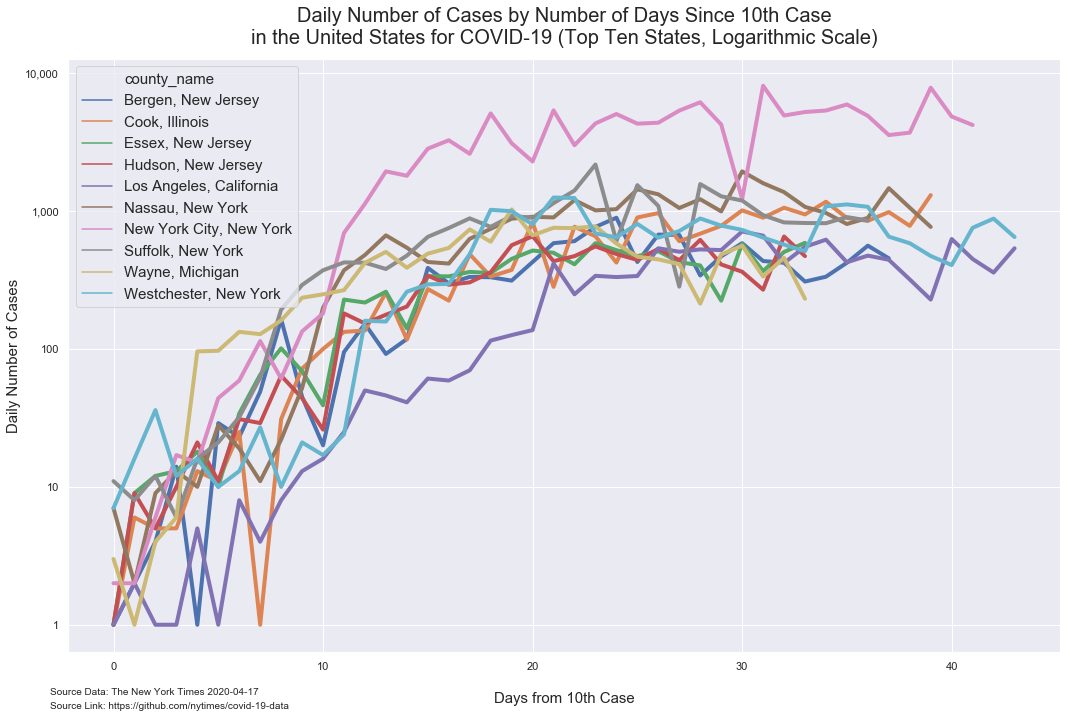

In [53]:
fig, ax1 = plt.subplots(figsize=(15,10))
txt = ('Source Data: The New York Times ' + current_date)
txt2 = ('Source Link: https://github.com/nytimes/covid-19-data')
sns.lineplot(x="days_since_ten_case", y="daily_cases",
             hue="county_name",
             data=temp_fill_zeros, linewidth=4)

ax1.set_yscale('log')

ax1.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax1.xaxis.labelpad = 20

ax1.grid(True)
ax1.grid(axis='x', which='minor')

ax1.legend(loc='upper left', fontsize=15)
ax1.set_xlabel('Days from 10th Case', fontsize=15)
ax1.set_ylabel('Daily Number of Cases', fontsize=15)
plt.title('Daily Number of Cases by Number of Days Since 10th Case\nin the United States for COVID-19 (Top Ten States, Logarithmic Scale)', pad = 15, fontsize=20)
plt.figtext(0.05, 0.03, txt, wrap=True, horizontalalignment='left', fontsize=10)
plt.figtext(0.05, 0.01, txt2, wrap=True, horizontalalignment='left', fontsize=10)

plt.tight_layout()
plt.savefig('figures/10-cases-timeseries-by-county-top-10-daily-log')

In [54]:
county_ten_cases['daily_cases'].loc[county_ten_cases.daily_cases == 0]

52     0.0
127    0.0
397    0.0
437    0.0
Name: daily_cases, dtype: float64

# Daily Number of Cases Since 10th Case (Weekly Average)

In [55]:
county_ten_cases_weekly = county_ten_cases.sort_values(by=['county_name', 'date','cases'], 
                                                    ascending=[True, True, True])

In [56]:
county_ten_cases_weekly[0:30]

date  county         county_name  cases  daily_cases  deaths  \
223 2020-03-11  Bergen  Bergen, New Jersey     11          1.0       1   
224 2020-03-12  Bergen  Bergen, New Jersey     13          2.0       1   
225 2020-03-13  Bergen  Bergen, New Jersey     17          4.0       1   
226 2020-03-14  Bergen  Bergen, New Jersey     31         14.0       1   
227 2020-03-15  Bergen  Bergen, New Jersey     32          1.0       1   
228 2020-03-16  Bergen  Bergen, New Jersey     61         29.0       2   
229 2020-03-17  Bergen  Bergen, New Jersey     84         23.0       2   
230 2020-03-18  Bergen  Bergen, New Jersey    133         49.0       4   
231 2020-03-19  Bergen  Bergen, New Jersey    297        164.0       6   
232 2020-03-20  Bergen  Bergen, New Jersey    342         45.0       7   
233 2020-03-21  Bergen  Bergen, New Jersey    362         20.0       9   
234 2020-03-22  Bergen  Bergen, New Jersey    457         95.0      10   
235 2020-03-23  Bergen  Bergen, New Jersey    609        152.0      12   
236 2020-03-24  Bergen  Bergen, New Jersey    701         92.0      14   
237 2020-03-25  Bergen  Bergen, New Jersey    819        118.0      15   
238 2020-03-26  Bergen  Bergen, New Jersey   1206        387.0      21   
239 2020-03-27  Bergen  Bergen, New Jersey   1505        299.0      28   
240 2020-03-28  Bergen  Bergen, New Jersey   1838        333.0      35   
241 2020-03-29  Bergen  Bergen, New Jersey   2169        331.0      35   
242 2020-03-30  Bergen  Bergen, New Jersey   2482        313.0      41   
243 2020-03-31  Bergen  Bergen, New Jersey   2909        427.0      53   
244 2020-04-01  Bergen  Bergen, New Jersey   3494        585.0      75   
245 2020-04-02  Bergen  Bergen, New Jersey   4099        605.0     120   
246 2020-04-03  Bergen  Bergen, New Jersey   4866        767.0     132   
247 2020-04-04  Bergen  Bergen, New Jersey   5760        894.0     179   
248 2020-04-05  Bergen  Bergen, New Jersey   6187        427.0     189   
249 2020-04-06  Bergen  Bergen, New Jersey   6862        675.0     200   
250 2020-04-07  Bergen  Bergen, New Jersey   7533        671.0     263   
251 2020-04-08  Bergen  Bergen, New Jersey   7874        341.0     314   
252 2020-04-09  Bergen  Bergen, New Jersey   8343        469.0     345   

    date_ten_case  days_since_ten_case  
223    2020-03-11                    0  
224    2020-03-11                    1  
225    2020-03-11                    2  
226    2020-03-11                    3  
227    2020-03-11                    4  
228    2020-03-11                    5  
229    2020-03-11                    6  
230    2020-03-11                    7  
231    2020-03-11                    8  
232    2020-03-11                    9  
233    2020-03-11                   10  
234    2020-03-11                   11  
235    2020-03-11                   12  
236    2020-03-11                   13  
237    2020-03-11                   14  
238    2020-03-11                   15  
239    2020-03-11                   16  
240    2020-03-11                   17  
241    2020-03-11                   18  
242    2020-03-11                   19  
243    2020-03-11                   20  
244    2020-03-11                   21  
245    2020-03-11                   22  
246    2020-03-11                   23  
247    2020-03-11                   24  
248    2020-03-11                   25  
249    2020-03-11                   26  
250    2020-03-11                   27  
251    2020-03-11                   28  
252    2020-03-11                   29

In [57]:
county_ten_cases_weekly = county_ten_cases_weekly.set_index('date').groupby('county_name').resample('W').agg({'days_since_ten_case': 
                                                                    np.max, 'daily_cases': np.mean})

In [58]:
county_ten_cases_weekly

days_since_ten_case  daily_cases
county_name           date                                        
Bergen, New Jersey    2020-03-15                    4     4.400000
                      2020-03-22                   11    60.714286
                      2020-03-29                   18   244.571429
                      2020-04-05                   25   574.000000
                      2020-04-12                   32   513.857143
...                                               ...          ...
Westchester, New York 2020-03-22                   17   239.714286
                      2020-03-29                   24   949.428571
                      2020-04-05                   31   743.285714
                      2020-04-12                   38   798.714286
                      2020-04-19                   43   632.600000

[63 rows x 2 columns]

In [59]:
county_ten_cases_weekly.reset_index(inplace=True)
county_ten_cases_weekly.rename(columns={'daily_cases': 'daily_cases_week_average'}, inplace=True)

In [60]:
county_ten_cases_weekly

county_name       date  days_since_ten_case  \
0      Bergen, New Jersey 2020-03-15                    4   
1      Bergen, New Jersey 2020-03-22                   11   
2      Bergen, New Jersey 2020-03-29                   18   
3      Bergen, New Jersey 2020-04-05                   25   
4      Bergen, New Jersey 2020-04-12                   32   
..                    ...        ...                  ...   
58  Westchester, New York 2020-03-22                   17   
59  Westchester, New York 2020-03-29                   24   
60  Westchester, New York 2020-04-05                   31   
61  Westchester, New York 2020-04-12                   38   
62  Westchester, New York 2020-04-19                   43   

    daily_cases_week_average  
0                   4.400000  
1                  60.714286  
2                 244.571429  
3                 574.000000  
4                 513.857143  
..                       ...  
58                239.714286  
59                949.428571  
60                743.285714  
61                798.714286  
62                632.600000  

[63 rows x 4 columns]

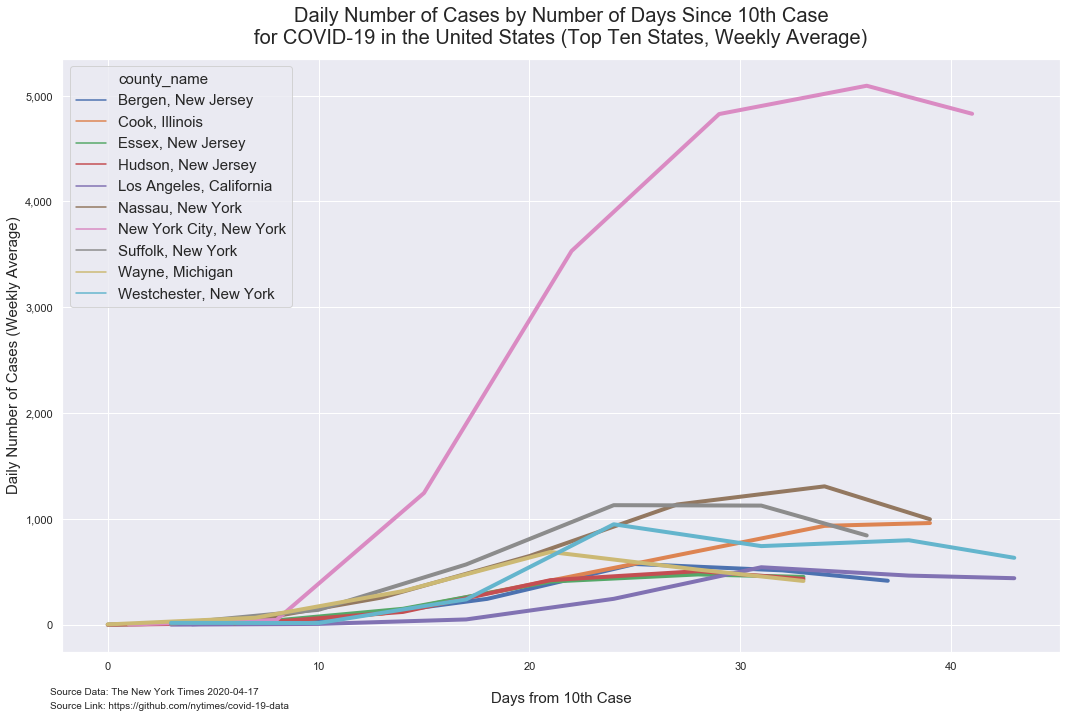

In [61]:
fig, ax1 = plt.subplots(figsize=(15,10))
txt = ('Source Data: The New York Times ' + current_date)
txt2 = ('Source Link: https://github.com/nytimes/covid-19-data')
sns.lineplot(x="days_since_ten_case", y="daily_cases_week_average",
             hue="county_name",
             data=county_ten_cases_weekly, linewidth=4)

ax1.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax1.xaxis.labelpad = 20

ax1.grid(True)
ax1.grid(axis='x', which='minor')

ax1.legend(loc='upper left', fontsize=15)
ax1.set_xlabel('Days from 10th Case', fontsize=15)
ax1.set_ylabel('Daily Number of Cases (Weekly Average)', fontsize=15)
plt.title('Daily Number of Cases by Number of Days Since 10th Case\nfor COVID-19 in the United States (Top Ten States, Weekly Average)', pad = 15, fontsize=20)
plt.figtext(0.05, 0.03, txt, wrap=True, horizontalalignment='left', fontsize=10)
plt.figtext(0.05, 0.01, txt2, wrap=True, horizontalalignment='left', fontsize=10)

plt.tight_layout()
plt.savefig('figures/10-cases-timeseries-by-county-top-10-weekly')

In [62]:
county_ten_cases_weekly.sort_values(by='daily_cases_week_average')

county_name       date  days_since_ten_case  \
18       Hudson, New Jersey 2020-03-15                    0   
24  Los Angeles, California 2020-03-08                    3   
12        Essex, New Jersey 2020-03-15                    0   
37  New York City, New York 2020-03-08                    1   
50          Wayne, Michigan 2020-03-15                    0   
..                      ...        ...                  ...   
35         Nassau, New York 2020-04-12                   34   
40  New York City, New York 2020-03-29                   22   
41  New York City, New York 2020-04-05                   29   
43  New York City, New York 2020-04-19                   41   
42  New York City, New York 2020-04-12                   36   

    daily_cases_week_average  
18                  0.000000  
24                  1.000000  
12                  1.000000  
37                  2.000000  
50                  3.000000  
..                       ...  
35               1307.857143  
40               3531.857143  
41               4826.285714  
43               4828.800000  
42               5093.714286  

[63 rows x 4 columns]

In [63]:
temp_fill_zeros = county_ten_cases_weekly.sort_values(by=['county_name', 'date','daily_cases_week_average'], 
                                                 ascending=[True, True, True])

temp_fill_zeros['daily_cases_week_average'].loc[temp_fill_zeros.daily_cases_week_average == 0] = 1

temp_fill_zeros

county_name       date  days_since_ten_case  \
0      Bergen, New Jersey 2020-03-15                    4   
1      Bergen, New Jersey 2020-03-22                   11   
2      Bergen, New Jersey 2020-03-29                   18   
3      Bergen, New Jersey 2020-04-05                   25   
4      Bergen, New Jersey 2020-04-12                   32   
..                    ...        ...                  ...   
58  Westchester, New York 2020-03-22                   17   
59  Westchester, New York 2020-03-29                   24   
60  Westchester, New York 2020-04-05                   31   
61  Westchester, New York 2020-04-12                   38   
62  Westchester, New York 2020-04-19                   43   

    daily_cases_week_average  
0                   4.400000  
1                  60.714286  
2                 244.571429  
3                 574.000000  
4                 513.857143  
..                       ...  
58                239.714286  
59                949.428571  
60                743.285714  
61                798.714286  
62                632.600000  

[63 rows x 4 columns]

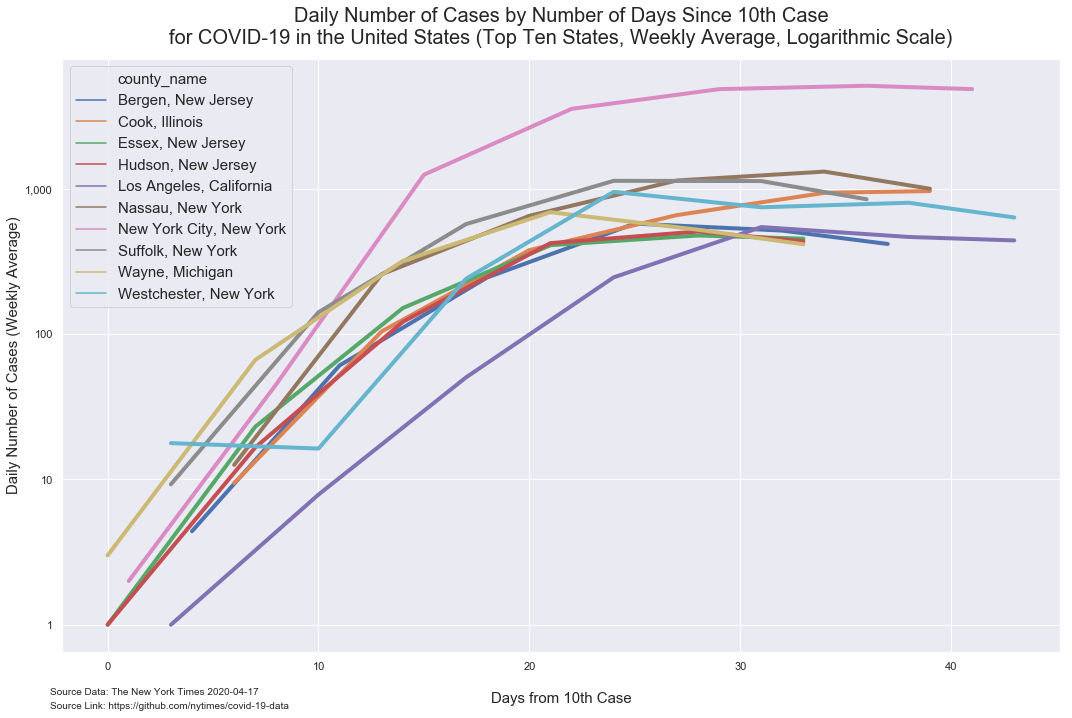

In [64]:
fig, ax1 = plt.subplots(figsize=(15,10))
txt = ('Source Data: The New York Times ' + current_date)
txt2 = ('Source Link: https://github.com/nytimes/covid-19-data')

sns.lineplot(x="days_since_ten_case", y="daily_cases_week_average",
             hue="county_name",
             data=temp_fill_zeros, linewidth=4)

ax1.set_yscale('log')

ax1.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax1.xaxis.labelpad = 20

ax1.grid(True)
ax1.grid(axis='x', which='minor')

ax1.legend(loc='upper left', fontsize=15)
ax1.set_xlabel('Days from 10th Case', fontsize=15)
ax1.set_ylabel('Daily Number of Cases (Weekly Average)', fontsize=15)
plt.title('Daily Number of Cases by Number of Days Since 10th Case\nfor COVID-19 in the United States (Top Ten States, Weekly Average, Logarithmic Scale)', pad = 15, fontsize=20)
plt.figtext(0.05, 0.03, txt, wrap=True, horizontalalignment='left', fontsize=10)
plt.figtext(0.05, 0.01, txt2, wrap=True, horizontalalignment='left', fontsize=10)

plt.tight_layout()
plt.savefig('figures/10-cases-timeseries-by-county-top-10-weekly-log')

# Calculating Growth Rate = Cases Today / Cases the Previous Day

In [65]:
growth_rate = county_ten_cases.sort_values(by=['county_name', 'date', 'cases'], 
                                                ascending=[True, True, True])

In [66]:
growth_rate.head()

date  county         county_name  cases  daily_cases  deaths  \
223 2020-03-11  Bergen  Bergen, New Jersey     11          1.0       1   
224 2020-03-12  Bergen  Bergen, New Jersey     13          2.0       1   
225 2020-03-13  Bergen  Bergen, New Jersey     17          4.0       1   
226 2020-03-14  Bergen  Bergen, New Jersey     31         14.0       1   
227 2020-03-15  Bergen  Bergen, New Jersey     32          1.0       1   

    date_ten_case  days_since_ten_case  
223    2020-03-11                    0  
224    2020-03-11                    1  
225    2020-03-11                    2  
226    2020-03-11                    3  
227    2020-03-11                    4

In [67]:
growth_rate['growth_rate'] = (growth_rate['daily_cases'] / growth_rate['daily_cases'].shift(1))

In [68]:
growth_rate[:50]

date  county         county_name  cases  daily_cases  deaths  \
223 2020-03-11  Bergen  Bergen, New Jersey     11          1.0       1   
224 2020-03-12  Bergen  Bergen, New Jersey     13          2.0       1   
225 2020-03-13  Bergen  Bergen, New Jersey     17          4.0       1   
226 2020-03-14  Bergen  Bergen, New Jersey     31         14.0       1   
227 2020-03-15  Bergen  Bergen, New Jersey     32          1.0       1   
228 2020-03-16  Bergen  Bergen, New Jersey     61         29.0       2   
229 2020-03-17  Bergen  Bergen, New Jersey     84         23.0       2   
230 2020-03-18  Bergen  Bergen, New Jersey    133         49.0       4   
231 2020-03-19  Bergen  Bergen, New Jersey    297        164.0       6   
232 2020-03-20  Bergen  Bergen, New Jersey    342         45.0       7   
233 2020-03-21  Bergen  Bergen, New Jersey    362         20.0       9   
234 2020-03-22  Bergen  Bergen, New Jersey    457         95.0      10   
235 2020-03-23  Bergen  Bergen, New Jersey    609        152.0      12   
236 2020-03-24  Bergen  Bergen, New Jersey    701         92.0      14   
237 2020-03-25  Bergen  Bergen, New Jersey    819        118.0      15   
238 2020-03-26  Bergen  Bergen, New Jersey   1206        387.0      21   
239 2020-03-27  Bergen  Bergen, New Jersey   1505        299.0      28   
240 2020-03-28  Bergen  Bergen, New Jersey   1838        333.0      35   
241 2020-03-29  Bergen  Bergen, New Jersey   2169        331.0      35   
242 2020-03-30  Bergen  Bergen, New Jersey   2482        313.0      41   
243 2020-03-31  Bergen  Bergen, New Jersey   2909        427.0      53   
244 2020-04-01  Bergen  Bergen, New Jersey   3494        585.0      75   
245 2020-04-02  Bergen  Bergen, New Jersey   4099        605.0     120   
246 2020-04-03  Bergen  Bergen, New Jersey   4866        767.0     132   
247 2020-04-04  Bergen  Bergen, New Jersey   5760        894.0     179   
248 2020-04-05  Bergen  Bergen, New Jersey   6187        427.0     189   
249 2020-04-06  Bergen  Bergen, New Jersey   6862        675.0     200   
250 2020-04-07  Bergen  Bergen, New Jersey   7533        671.0     263   
251 2020-04-08  Bergen  Bergen, New Jersey   7874        341.0     314   
252 2020-04-09  Bergen  Bergen, New Jersey   8343        469.0     345   
253 2020-04-10  Bergen  Bergen, New Jersey   8928        585.0     390   
254 2020-04-11  Bergen  Bergen, New Jersey   9362        434.0     435   
255 2020-04-12  Bergen  Bergen, New Jersey   9784        422.0     453   
256 2020-04-13  Bergen  Bergen, New Jersey  10092        308.0     482   
257 2020-04-14  Bergen  Bergen, New Jersey  10426        334.0     550   
258 2020-04-15  Bergen  Bergen, New Jersey  10848        422.0     608   
259 2020-04-16  Bergen  Bergen, New Jersey  11409        561.0     668   
260 2020-04-17  Bergen  Bergen, New Jersey  11863        454.0     714   
45  2020-03-09    Cook      Cook, Illinois     11          1.0       0   
46  2020-03-10    Cook      Cook, Illinois     17          6.0       0   
47  2020-03-11    Cook      Cook, Illinois     22          5.0       0   
48  2020-03-12    Cook      Cook, Illinois     27          5.0       0   
49  2020-03-13    Cook      Cook, Illinois     40         13.0       0   
50  2020-03-14    Cook      Cook, Illinois     51         11.0       0   
51  2020-03-15    Cook      Cook, Illinois     76         25.0       0   
52  2020-03-16    Cook      Cook, Illinois     76          0.0       0   
53  2020-03-17    Cook      Cook, Illinois    107         31.0       1   
54  2020-03-18    Cook      Cook, Illinois    179         72.0       1   
55  2020-03-19    Cook      Cook, Illinois    279        100.0       2   
56  2020-03-20    Cook      Cook, Illinois    412        133.0       3   

    date_ten_case  days_since_ten_case  growth_rate  
223    2020-03-11                    0          NaN  
224    2020-03-11                    1     2.000000  
225    2020-03-11                    2     2.000000  
226    2020-03-11  

In [69]:
growth_rate = growth_rate.loc[growth_rate.days_since_ten_case != 0]

In [70]:
inf = [np.inf, -np.inf]
growth_rate['growth_rate'] = growth_rate['growth_rate'].replace(inf, np.nan)

In [71]:
growth_rate[:50]

date  county         county_name  cases  daily_cases  deaths  \
224 2020-03-12  Bergen  Bergen, New Jersey     13          2.0       1   
225 2020-03-13  Bergen  Bergen, New Jersey     17          4.0       1   
226 2020-03-14  Bergen  Bergen, New Jersey     31         14.0       1   
227 2020-03-15  Bergen  Bergen, New Jersey     32          1.0       1   
228 2020-03-16  Bergen  Bergen, New Jersey     61         29.0       2   
229 2020-03-17  Bergen  Bergen, New Jersey     84         23.0       2   
230 2020-03-18  Bergen  Bergen, New Jersey    133         49.0       4   
231 2020-03-19  Bergen  Bergen, New Jersey    297        164.0       6   
232 2020-03-20  Bergen  Bergen, New Jersey    342         45.0       7   
233 2020-03-21  Bergen  Bergen, New Jersey    362         20.0       9   
234 2020-03-22  Bergen  Bergen, New Jersey    457         95.0      10   
235 2020-03-23  Bergen  Bergen, New Jersey    609        152.0      12   
236 2020-03-24  Bergen  Bergen, New Jersey    701         92.0      14   
237 2020-03-25  Bergen  Bergen, New Jersey    819        118.0      15   
238 2020-03-26  Bergen  Bergen, New Jersey   1206        387.0      21   
239 2020-03-27  Bergen  Bergen, New Jersey   1505        299.0      28   
240 2020-03-28  Bergen  Bergen, New Jersey   1838        333.0      35   
241 2020-03-29  Bergen  Bergen, New Jersey   2169        331.0      35   
242 2020-03-30  Bergen  Bergen, New Jersey   2482        313.0      41   
243 2020-03-31  Bergen  Bergen, New Jersey   2909        427.0      53   
244 2020-04-01  Bergen  Bergen, New Jersey   3494        585.0      75   
245 2020-04-02  Bergen  Bergen, New Jersey   4099        605.0     120   
246 2020-04-03  Bergen  Bergen, New Jersey   4866        767.0     132   
247 2020-04-04  Bergen  Bergen, New Jersey   5760        894.0     179   
248 2020-04-05  Bergen  Bergen, New Jersey   6187        427.0     189   
249 2020-04-06  Bergen  Bergen, New Jersey   6862        675.0     200   
250 2020-04-07  Bergen  Bergen, New Jersey   7533        671.0     263   
251 2020-04-08  Bergen  Bergen, New Jersey   7874        341.0     314   
252 2020-04-09  Bergen  Bergen, New Jersey   8343        469.0     345   
253 2020-04-10  Bergen  Bergen, New Jersey   8928        585.0     390   
254 2020-04-11  Bergen  Bergen, New Jersey   9362        434.0     435   
255 2020-04-12  Bergen  Bergen, New Jersey   9784        422.0     453   
256 2020-04-13  Bergen  Bergen, New Jersey  10092        308.0     482   
257 2020-04-14  Bergen  Bergen, New Jersey  10426        334.0     550   
258 2020-04-15  Bergen  Bergen, New Jersey  10848        422.0     608   
259 2020-04-16  Bergen  Bergen, New Jersey  11409        561.0     668   
260 2020-04-17  Bergen  Bergen, New Jersey  11863        454.0     714   
46  2020-03-10    Cook      Cook, Illinois     17          6.0       0   
47  2020-03-11    Cook      Cook, Illinois     22          5.0       0   
48  2020-03-12    Cook      Cook, Illinois     27          5.0       0   
49  2020-03-13    Cook      Cook, Illinois     40         13.0       0   
50  2020-03-14    Cook      Cook, Illinois     51         11.0       0   
51  2020-03-15    Cook      Cook, Illinois     76         25.0       0   
52  2020-03-16    Cook      Cook, Illinois     76          0.0       0   
53  2020-03-17    Cook      Cook, Illinois    107         31.0       1   
54  2020-03-18    Cook      Cook, Illinois    179         72.0       1   
55  2020-03-19    Cook      Cook, Illinois    279        100.0       2   
56  2020-03-20    Cook      Cook, Illinois    412        133.0       3   
57  2020-03-21    Cook      Cook, Illinois    548        136.0       4   
58  2020-03-22    Cook      Cook, Illinois    805        257.0       6   

    date_ten_case  days_since_ten_case  growth_rate  
224    2020-03-11                    1     2.000000  
225    2020-03-11                    2     2.000000  
226    2020-03-11                    3     3.500000  
227    2020-03-11  

In [72]:
growth_rate['growth_rate'] = growth_rate['growth_rate'].fillna(method='ffill')

In [73]:
growth_rate.isna().sum()

date                   0
county                 0
county_name            0
cases                  0
daily_cases            0
deaths                 0
date_ten_case          0
days_since_ten_case    0
growth_rate            0
dtype: int64

In [74]:
growth_rate[:50]

date  county         county_name  cases  daily_cases  deaths  \
224 2020-03-12  Bergen  Bergen, New Jersey     13          2.0       1   
225 2020-03-13  Bergen  Bergen, New Jersey     17          4.0       1   
226 2020-03-14  Bergen  Bergen, New Jersey     31         14.0       1   
227 2020-03-15  Bergen  Bergen, New Jersey     32          1.0       1   
228 2020-03-16  Bergen  Bergen, New Jersey     61         29.0       2   
229 2020-03-17  Bergen  Bergen, New Jersey     84         23.0       2   
230 2020-03-18  Bergen  Bergen, New Jersey    133         49.0       4   
231 2020-03-19  Bergen  Bergen, New Jersey    297        164.0       6   
232 2020-03-20  Bergen  Bergen, New Jersey    342         45.0       7   
233 2020-03-21  Bergen  Bergen, New Jersey    362         20.0       9   
234 2020-03-22  Bergen  Bergen, New Jersey    457         95.0      10   
235 2020-03-23  Bergen  Bergen, New Jersey    609        152.0      12   
236 2020-03-24  Bergen  Bergen, New Jersey    701         92.0      14   
237 2020-03-25  Bergen  Bergen, New Jersey    819        118.0      15   
238 2020-03-26  Bergen  Bergen, New Jersey   1206        387.0      21   
239 2020-03-27  Bergen  Bergen, New Jersey   1505        299.0      28   
240 2020-03-28  Bergen  Bergen, New Jersey   1838        333.0      35   
241 2020-03-29  Bergen  Bergen, New Jersey   2169        331.0      35   
242 2020-03-30  Bergen  Bergen, New Jersey   2482        313.0      41   
243 2020-03-31  Bergen  Bergen, New Jersey   2909        427.0      53   
244 2020-04-01  Bergen  Bergen, New Jersey   3494        585.0      75   
245 2020-04-02  Bergen  Bergen, New Jersey   4099        605.0     120   
246 2020-04-03  Bergen  Bergen, New Jersey   4866        767.0     132   
247 2020-04-04  Bergen  Bergen, New Jersey   5760        894.0     179   
248 2020-04-05  Bergen  Bergen, New Jersey   6187        427.0     189   
249 2020-04-06  Bergen  Bergen, New Jersey   6862        675.0     200   
250 2020-04-07  Bergen  Bergen, New Jersey   7533        671.0     263   
251 2020-04-08  Bergen  Bergen, New Jersey   7874        341.0     314   
252 2020-04-09  Bergen  Bergen, New Jersey   8343        469.0     345   
253 2020-04-10  Bergen  Bergen, New Jersey   8928        585.0     390   
254 2020-04-11  Bergen  Bergen, New Jersey   9362        434.0     435   
255 2020-04-12  Bergen  Bergen, New Jersey   9784        422.0     453   
256 2020-04-13  Bergen  Bergen, New Jersey  10092        308.0     482   
257 2020-04-14  Bergen  Bergen, New Jersey  10426        334.0     550   
258 2020-04-15  Bergen  Bergen, New Jersey  10848        422.0     608   
259 2020-04-16  Bergen  Bergen, New Jersey  11409        561.0     668   
260 2020-04-17  Bergen  Bergen, New Jersey  11863        454.0     714   
46  2020-03-10    Cook      Cook, Illinois     17          6.0       0   
47  2020-03-11    Cook      Cook, Illinois     22          5.0       0   
48  2020-03-12    Cook      Cook, Illinois     27          5.0       0   
49  2020-03-13    Cook      Cook, Illinois     40         13.0       0   
50  2020-03-14    Cook      Cook, Illinois     51         11.0       0   
51  2020-03-15    Cook      Cook, Illinois     76         25.0       0   
52  2020-03-16    Cook      Cook, Illinois     76          0.0       0   
53  2020-03-17    Cook      Cook, Illinois    107         31.0       1   
54  2020-03-18    Cook      Cook, Illinois    179         72.0       1   
55  2020-03-19    Cook      Cook, Illinois    279        100.0       2   
56  2020-03-20    Cook      Cook, Illinois    412        133.0       3   
57  2020-03-21    Cook      Cook, Illinois    548        136.0       4   
58  2020-03-22    Cook      Cook, Illinois    805        257.0       6   

    date_ten_case  days_since_ten_case  growth_rate  
224    2020-03-11                    1     2.000000  
225    2020-03-11                    2     2.000000  
226    2020-03-11                    3     3.500000  
227    2020-03-11  

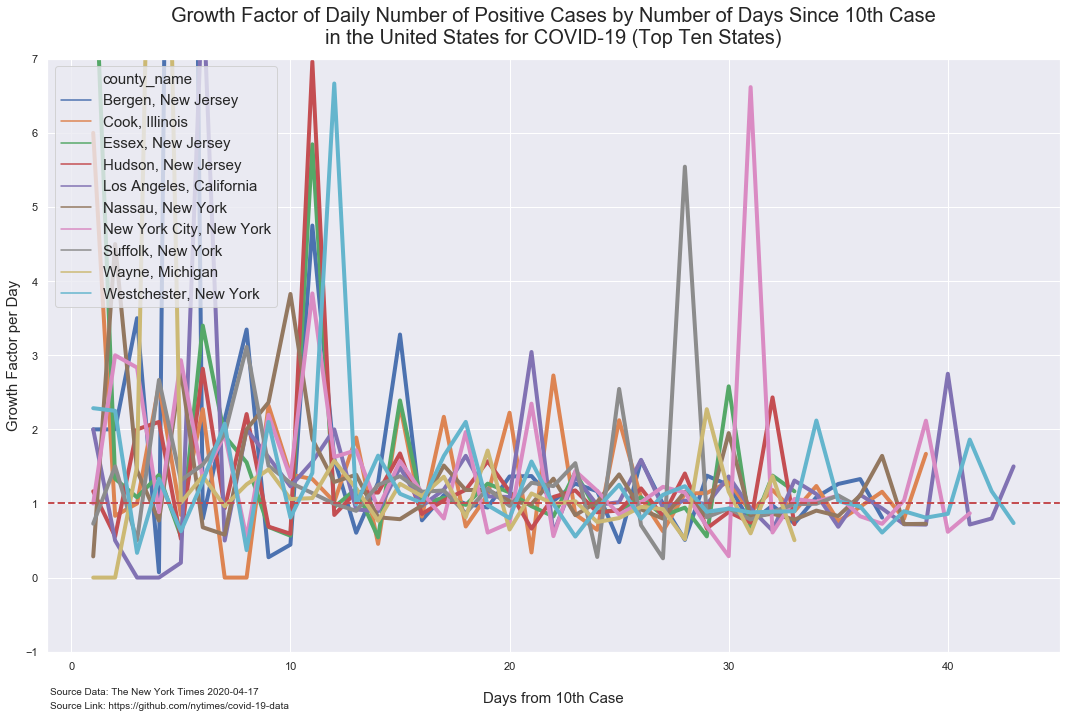

In [75]:
fig, ax1 = plt.subplots(figsize=(15,10))
txt = ('Source Data: The New York Times ' + current_date)
txt2 = ('Source Link: https://github.com/nytimes/covid-19-data')

sns.lineplot(x="days_since_ten_case", y="growth_rate",
             hue="county_name", data=growth_rate , linewidth=4)

ax1.axhline(1, color='r', lw=2, linestyle='dashed')

ax1.xaxis.labelpad = 20

ax1.grid(True)
ax1.grid(axis='x', which='minor')
plt.ylim(-1, 7)

ax1.legend(loc='upper left', fontsize=15)
ax1.set_xlabel('Days from 10th Case', fontsize=15)
ax1.set_ylabel('Growth Factor per Day', fontsize=15)
plt.title('Growth Factor of Daily Number of Positive Cases by Number of Days Since 10th Case\nin the United States for COVID-19 (Top Ten States)', pad = 15, fontsize=20)
plt.figtext(0.05, 0.03, txt, wrap=True, horizontalalignment='left', fontsize=10)
plt.figtext(0.05, 0.01, txt2, wrap=True, horizontalalignment='left', fontsize=10)

plt.tight_layout()
plt.savefig('figures/growth-factor-top-10-daily')

# Weekly Growth Rate

In [76]:
growth_rate_weekly = growth_rate.set_index('date').groupby('county_name').resample('W').agg({'days_since_ten_case': 
                                                                    np.max, 'growth_rate': np.mean})

In [77]:
growth_rate_weekly

days_since_ten_case  growth_rate
county_name             date                                        
Bergen, New Jersey      2020-03-15                    4     1.892857
                        2020-03-22                   11     5.819902
                        2020-03-29                   18     1.378264
                        2020-04-05                   25     1.089289
                        2020-04-12                   32     1.060000
                        2020-04-19                   37     1.043280
Cook, Illinois          2020-03-15                    6     2.258702
                        2020-03-22                   13     1.136247
                        2020-03-29                   20     1.400504
                        2020-04-05                   27     1.198240
                        2020-04-12                   34     1.109290
                        2020-04-19                   39     1.067626
Essex, New Jersey       2020-03-22                    7     2.666943
                        2020-03-29                   14     1.620086
                        2020-04-05                   21     1.260699
                        2020-04-12                   28     0.986808
                        2020-04-19                   33     1.262303
Hudson, New Jersey      2020-03-22                    7     1.442484
                        2020-03-29                   14     1.942272
                        2020-04-05                   21     1.164225
                        2020-04-12                   28     1.069403
                        2020-04-19                   33     1.088251
Los Angeles, California 2020-03-08                    3     0.833333
                        2020-03-15                   10     1.936538
                        2020-03-22                   17     1.287895
                        2020-03-29                   24     1.401075
                        2020-04-05                   31     1.125171
                        2020-04-12                   38     0.932305
                        2020-04-19                   43     1.295634
Nassau, New York        2020-03-15                    6     1.746327
                        2020-03-22                   13     1.902382
                        2020-03-29                   20     1.069334
                        2020-04-05                   27     1.042336
                        2020-04-12                   34     1.041731
                        2020-04-19                   39     1.005669
New York City, New York 2020-03-08                    1     1.000000
                        2020-03-15                    8     1.922460
                        2020-03-22                   15     1.889723
                        2020-03-29                   22     1.166089
                        2020-04-05                   29     1.077089
                        2020-04-12                   36     1.647572
                        2020-04-19                   41     1.074082
Suffolk, New York       2020-03-15                    3     0.909091
                        2020-03-22                   10     1.905643
                        2020-03-29                   17     1.141103
                        2020-04-05                   24     1.053037
                        2020-04-12                   31     1.655138
                        2020-04-19                   36     0.984896
Wayne, Michigan         2020-03-22                    7     2.977708
                        2020-03-29                   14     1.199254
                        2020-04-05                   21     1.148498
                        2020-04-12                   28     0.853507
                        2020-04-19                   33     1.180014
Westchester, New York   2020-03-08                    3     1.623016
                        2020-03-15                   10     1.230736
                        2020-03-22                   17     2.070138
                        2020-03-29

In [78]:
growth_rate_weekly.reset_index(inplace=True)
growth_rate_weekly.rename(columns={'growth_rate': 'growth_rate_weekly_average'}, inplace=True)

In [79]:
growth_rate_weekly

county_name       date  days_since_ten_case  \
0        Bergen, New Jersey 2020-03-15                    4   
1        Bergen, New Jersey 2020-03-22                   11   
2        Bergen, New Jersey 2020-03-29                   18   
3        Bergen, New Jersey 2020-04-05                   25   
4        Bergen, New Jersey 2020-04-12                   32   
5        Bergen, New Jersey 2020-04-19                   37   
6            Cook, Illinois 2020-03-15                    6   
7            Cook, Illinois 2020-03-22                   13   
8            Cook, Illinois 2020-03-29                   20   
9            Cook, Illinois 2020-04-05                   27   
10           Cook, Illinois 2020-04-12                   34   
11           Cook, Illinois 2020-04-19                   39   
12        Essex, New Jersey 2020-03-22                    7   
13        Essex, New Jersey 2020-03-29                   14   
14        Essex, New Jersey 2020-04-05                   21   
15        Essex, New Jersey 2020-04-12                   28   
16        Essex, New Jersey 2020-04-19                   33   
17       Hudson, New Jersey 2020-03-22                    7   
18       Hudson, New Jersey 2020-03-29                   14   
19       Hudson, New Jersey 2020-04-05                   21   
20       Hudson, New Jersey 2020-04-12                   28   
21       Hudson, New Jersey 2020-04-19                   33   
22  Los Angeles, California 2020-03-08                    3   
23  Los Angeles, California 2020-03-15                   10   
24  Los Angeles, California 2020-03-22                   17   
25  Los Angeles, California 2020-03-29                   24   
26  Los Angeles, California 2020-04-05                   31   
27  Los Angeles, California 2020-04-12                   38   
28  Los Angeles, California 2020-04-19                   43   
29         Nassau, New York 2020-03-15                    6   
30         Nassau, New York 2020-03-22                   13   
31         Nassau, New York 2020-03-29                   20   
32         Nassau, New York 2020-04-05                   27   
33         Nassau, New York 2020-04-12                   34   
34         Nassau, New York 2020-04-19                   39   
35  New York City, New York 2020-03-08                    1   
36  New York City, New York 2020-03-15                    8   
37  New York City, New York 2020-03-22                   15   
38  New York City, New York 2020-03-29                   22   
39  New York City, New York 2020-04-05                   29   
40  New York City, New York 2020-04-12                   36   
41  New York City, New York 2020-04-19                   41   
42        Suffolk, New York 2020-03-15                    3   
43        Suffolk, New York 2020-03-22                   10   
44        Suffolk, New York 2020-03-29                   17   
45        Suffolk, New York 2020-04-05                   24   
46        Suffolk, New York 2020-04-12                   31   
47        Suffolk, New York 2020-04-19                   36   
48          Wayne, Michigan 2020-03-22                    7   
49          Wayne, Michigan 2020-03-29                   14   
50          Wayne, Michigan 2020-04-05                   21   
51          Wayne, Michigan 2020-04-12                   28   
52          Wayne, Michigan 2020-04-19                   33   
53    Westchester, New York 2020-03-08                    3   
54    Westchester, New York 2020-03-15                   10   
55    Westchester, New York 2020-03-22                   17   
56    Westchester, New York 2020-03-29                   24   
57    Westchester, New York 2020-04-05                   31   
58    Westchester, New York 2020-04-12                   38   
59    Westchester, New York 2020-04-19                   43   

    growth_rate_weekly_average  
0                     1.892857  
1                     5.819902  
2                     1.378264  
3                     1.089289  
4      

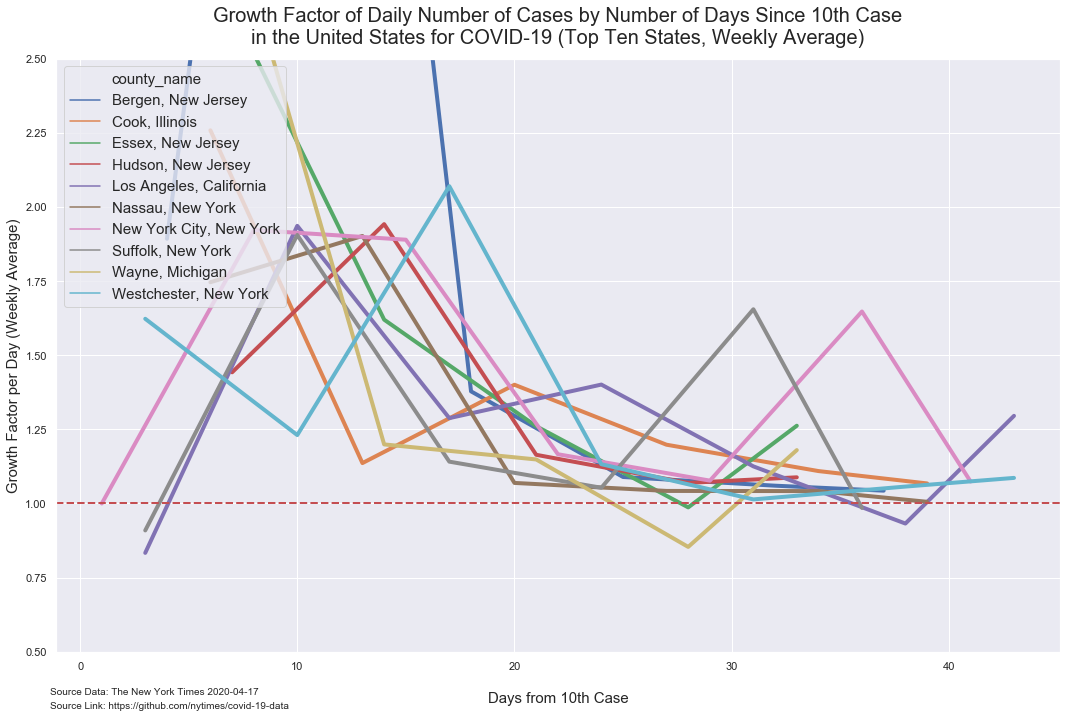

In [80]:
fig, ax1 = plt.subplots(figsize=(15,10))
txt = ('Source Data: The New York Times ' + current_date)
txt2 = ('Source Link: https://github.com/nytimes/covid-19-data')

sns.lineplot(x="days_since_ten_case", y="growth_rate_weekly_average",
             hue="county_name", data=growth_rate_weekly, linewidth=4)

ax1.axhline(1, color='r', lw=2, linestyle='dashed')

ax1.xaxis.labelpad = 20

ax1.grid(True)
ax1.grid(axis='x', which='minor')
plt.ylim(0.5, 2.5)

ax1.legend(loc='upper left', fontsize=15)
ax1.set_xlabel('Days from 10th Case', fontsize=15)
ax1.set_ylabel('Growth Factor per Day (Weekly Average)', fontsize=15)
plt.title('Growth Factor of Daily Number of Cases by Number of Days Since 10th Case\nin the United States for COVID-19 (Top Ten States, Weekly Average)', pad = 15, fontsize=20)
plt.figtext(0.05, 0.03, txt, wrap=True, horizontalalignment='left', fontsize=10)
plt.figtext(0.05, 0.01, txt2, wrap=True, horizontalalignment='left', fontsize=10)

plt.tight_layout()
plt.savefig('figures/growth-factor-top-10-weekly')

# Cumulative Number of Cases

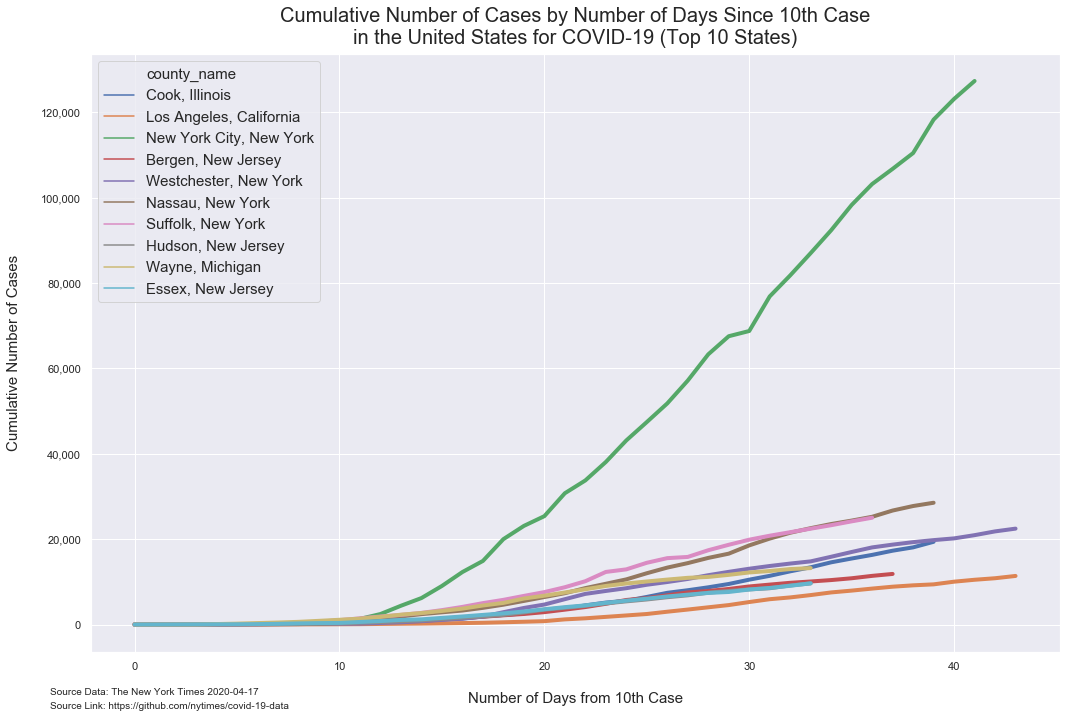

In [81]:
fig, ax1 = plt.subplots(figsize=(15,10))
txt = ('Source Data: The New York Times ' + current_date)
txt2 = ('Source Link: https://github.com/nytimes/covid-19-data')

sns.lineplot(x="days_since_ten_case", y="cases",
             hue="county_name",
             data=county_ten_cases, linewidth=4)

ax1.xaxis.grid(True, which="major")
ax1.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

ax1.grid(True)
ax1.grid(axis='x', which='minor')
ax1.xaxis.labelpad = 20
ax1.yaxis.labelpad = 20

ax1.legend(fontsize=15)
ax1.set_xlabel('Number of Days from 10th Case', fontsize=15)
ax1.set_ylabel('Cumulative Number of Cases', fontsize=15)
plt.title('Cumulative Number of Cases by Number of Days Since 10th Case\nin the United States for COVID-19 (Top 10 States)', 
          pad = 10, fontsize=20)
plt.figtext(0.05, 0.03, txt, wrap=True, horizontalalignment='left', fontsize=10)
plt.figtext(0.05, 0.01, txt2, wrap=True, horizontalalignment='left', fontsize=10)

plt.tight_layout()
plt.savefig('figures/county-timeseries-tenth-case')

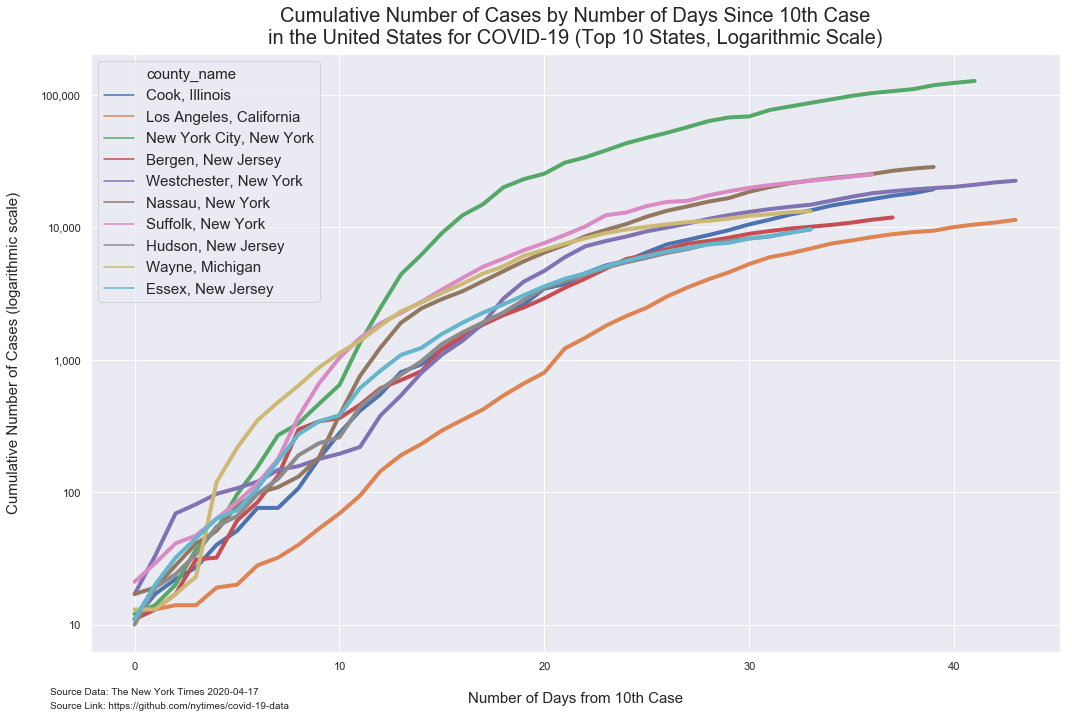

In [82]:
fig, ax1 = plt.subplots(figsize=(15,10))
txt = ('Source Data: The New York Times ' + current_date)
txt2 = ('Source Link: https://github.com/nytimes/covid-19-data')

sns.lineplot(x="days_since_ten_case", y="cases",
             hue="county_name",
             data=county_ten_cases, linewidth=4)
    
ax1.set_yscale('log')

ax1.xaxis.grid(True, which="major")
ax1.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

ax1.grid(True)
ax1.grid(axis='x', which='minor')
ax1.xaxis.labelpad = 20
ax1.yaxis.labelpad = 20

ax1.legend(fontsize=15)
ax1.set_xlabel('Number of Days from 10th Case', fontsize=15)
ax1.set_ylabel('Cumulative Number of Cases (logarithmic scale)', fontsize=15)
plt.title('Cumulative Number of Cases by Number of Days Since 10th Case\nin the United States for COVID-19 (Top 10 States, Logarithmic Scale)', 
          pad = 10, fontsize=20)
plt.figtext(0.05, 0.03, txt, wrap=True, horizontalalignment='left', fontsize=10)
plt.figtext(0.05, 0.01, txt2, wrap=True, horizontalalignment='left', fontsize=10)

plt.tight_layout()
plt.savefig('figures/county-timeseries-tenth-case-log')

# Cumulative Cases for All States

In [83]:
ten_cases_all_states = covid_19_counties_data.loc[covid_19_counties_data['cases'] >= 10]

In [84]:
ten_cases_all_states = ten_cases_all_states.sort_values(by=['date', 'cases'], 
                                ascending=[True, True], ).drop_duplicates(subset ="county_name", keep = 'first').reset_index(drop=True)

In [85]:
ten_cases_all_states = ten_cases_all_states[['county_name', 'date']]
ten_cases_all_states.rename(columns={'date': 'ten_cases_date'}, inplace=True)

In [86]:
ten_cases_all_states

county_name ten_cases_date
0           Douglas, Nebraska     2020-02-17
1                Bexar, Texas     2020-02-24
2          Solano, California     2020-02-26
3            King, Washington     2020-03-01
4     Santa Clara, California     2020-03-03
...                       ...            ...
1605            Dawson, Texas     2020-04-17
1606             Putnam, Ohio     2020-04-17
1607   Marion, South Carolina     2020-04-17
1608           San Juan, Utah     2020-04-17
1609         Dakota, Nebraska     2020-04-17

[1610 rows x 2 columns]

In [87]:
ten_cases_all_states = covid_19_counties_data.merge(ten_cases_all_states, left_on='county_name', right_on='county_name')

In [88]:
ten_cases_all_states = ten_cases_all_states.loc[ten_cases_all_states['cases'] >= 10]

In [89]:
ten_cases_all_states

date                 county       state     fips  cases  deaths  \
44    2020-03-05              Snohomish  Washington  53061.0     17       0   
45    2020-03-06              Snohomish  Washington  53061.0     18       0   
46    2020-03-07              Snohomish  Washington  53061.0     26       0   
47    2020-03-08              Snohomish  Washington  53061.0     36       0   
48    2020-03-09              Snohomish  Washington  53061.0     45       0   
...          ...                    ...         ...      ...    ...     ...   
46918 2020-04-14  Colonial Heights city    Virginia  51570.0     16       0   
46919 2020-04-15  Colonial Heights city    Virginia  51570.0     17       0   
46920 2020-04-16  Colonial Heights city    Virginia  51570.0     18       0   
46921 2020-04-17  Colonial Heights city    Virginia  51570.0     19       0   
46927 2020-04-17                 Dakota    Nebraska  31043.0     22       0   

                           county_name ten_cases_date  
44               Snohomish, Washington     2020-03-05  
45               Snohomish, Washington     2020-03-05  
46               Snohomish, Washington     2020-03-05  
47               Snohomish, Washington     2020-03-05  
48               Snohomish, Washington     2020-03-05  
...                                ...            ...  
46918  Colonial Heights city, Virginia     2020-04-13  
46919  Colonial Heights city, Virginia     2020-04-13  
46920  Colonial Heights city, Virginia     2020-04-13  
46921  Colonial Heights city, Virginia     2020-04-13  
46927                 Dakota, Nebraska     2020-04-17  

[28424 rows x 8 columns]

In [90]:
ten_cases_all_states['days_from_10_cases'] = (ten_cases_all_states['date'] - 
                                              ten_cases_all_states['ten_cases_date']).dt.days

In [91]:
ten_cases_all_states

date                 county       state     fips  cases  deaths  \
44    2020-03-05              Snohomish  Washington  53061.0     17       0   
45    2020-03-06              Snohomish  Washington  53061.0     18       0   
46    2020-03-07              Snohomish  Washington  53061.0     26       0   
47    2020-03-08              Snohomish  Washington  53061.0     36       0   
48    2020-03-09              Snohomish  Washington  53061.0     45       0   
...          ...                    ...         ...      ...    ...     ...   
46918 2020-04-14  Colonial Heights city    Virginia  51570.0     16       0   
46919 2020-04-15  Colonial Heights city    Virginia  51570.0     17       0   
46920 2020-04-16  Colonial Heights city    Virginia  51570.0     18       0   
46921 2020-04-17  Colonial Heights city    Virginia  51570.0     19       0   
46927 2020-04-17                 Dakota    Nebraska  31043.0     22       0   

                           county_name ten_cases_date  days_from_10_cases  
44               Snohomish, Washington     2020-03-05                   0  
45               Snohomish, Washington     2020-03-05                   1  
46               Snohomish, Washington     2020-03-05                   2  
47               Snohomish, Washington     2020-03-05                   3  
48               Snohomish, Washington     2020-03-05                   4  
...                                ...            ...                 ...  
46918  Colonial Heights city, Virginia     2020-04-13                   1  
46919  Colonial Heights city, Virginia     2020-04-13                   2  
46920  Colonial Heights city, Virginia     2020-04-13                   3  
46921  Colonial Heights city, Virginia     2020-04-13                   4  
46927                 Dakota, Nebraska     2020-04-17                   0  

[28424 rows x 9 columns]

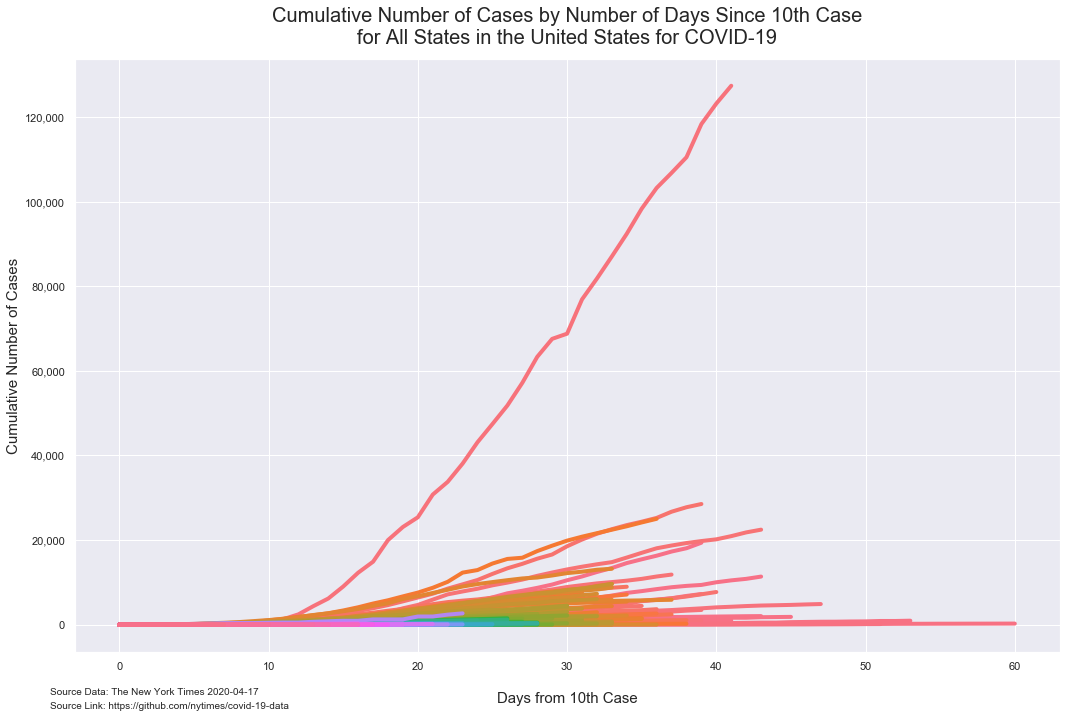

In [92]:
fig, ax1 = plt.subplots(figsize=(15,10))
txt = ('Source Data: The New York Times ' + current_date)
txt2 = ('Source Link: https://github.com/nytimes/covid-19-data')

sns.lineplot(x="days_from_10_cases", y="cases",
             hue="county_name",
             data=ten_cases_all_states, linewidth=4)

ax1.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax1.xaxis.labelpad = 20

ax1.grid(True)
ax1.grid(axis='x', which='minor')

ax1.legend_.remove()
ax1.set_xlabel('Days from 10th Case', fontsize=15)
ax1.set_ylabel('Cumulative Number of Cases', fontsize=15)
plt.title('Cumulative Number of Cases by Number of Days Since 10th Case\nfor All States in the United States for COVID-19', pad = 15, fontsize=20)
plt.figtext(0.05, 0.03, txt, wrap=True, horizontalalignment='left', fontsize=10)
plt.figtext(0.05, 0.01, txt2, wrap=True, horizontalalignment='left', fontsize=10)

plt.tight_layout()
plt.savefig('figures/10-cases-timeseries-all-counties')

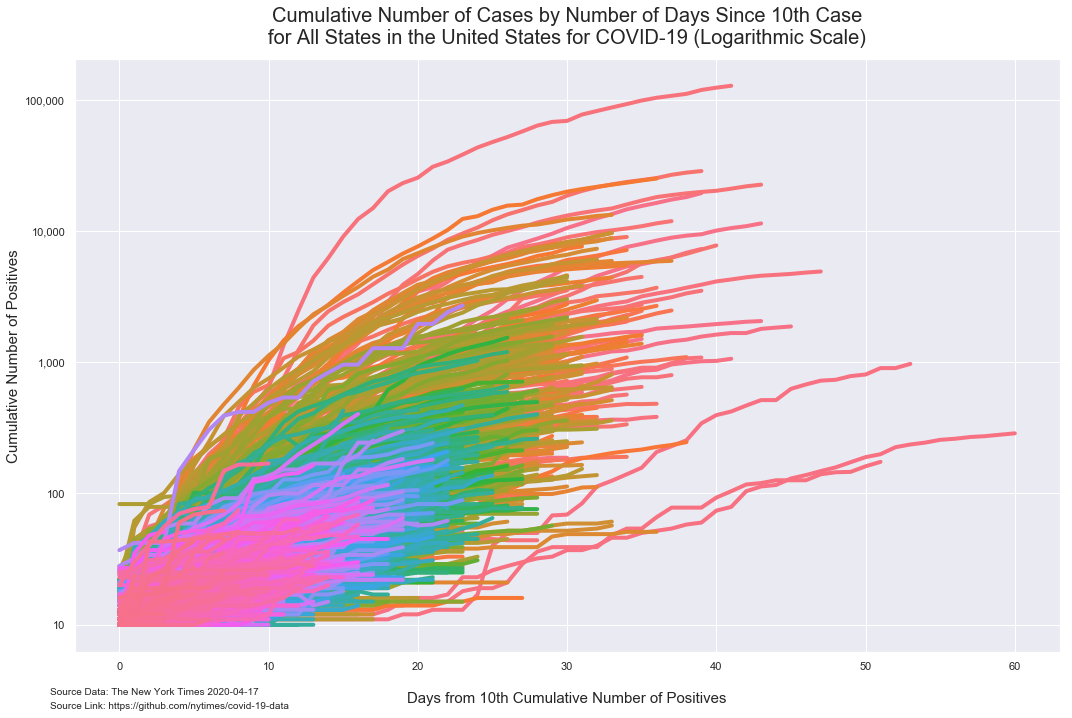

In [93]:
fig, ax1 = plt.subplots(figsize=(15,10))
txt = ('Source Data: The New York Times ' + current_date)
txt2 = ('Source Link: https://github.com/nytimes/covid-19-data')

sns.lineplot(x="days_from_10_cases", y="cases",
             hue="county_name",
             data=ten_cases_all_states, linewidth=4)
ax1.set_yscale('log')

ax1.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax1.xaxis.labelpad = 20

ax1.grid(True)
ax1.grid(axis='x', which='minor')

ax1.legend_.remove()
ax1.set_xlabel('Days from 10th Cumulative Number of Positives', fontsize=15)
ax1.set_ylabel('Cumulative Number of Positives', fontsize=15)
plt.title('Cumulative Number of Cases by Number of Days Since 10th Case\nfor All States in the United States for COVID-19 (Logarithmic Scale)', pad = 15, fontsize=20)
plt.figtext(0.05, 0.03, txt, wrap=True, horizontalalignment='left', fontsize=10)
plt.figtext(0.05, 0.01, txt2, wrap=True, horizontalalignment='left', fontsize=10)

plt.tight_layout()
plt.savefig('figures/10-cases-timeseries-all-counties-log')

# Trajectory Plots = daily number (log) vs. total number (log) 

## Daily

In [94]:
trajectory_plot = county_ten_cases.sort_values(by=['county_name', 'date','cases'], 
                                ascending=[True, True, True])

In [95]:
trajectory_plot[:50]

date  county         county_name  cases  daily_cases  deaths  \
223 2020-03-11  Bergen  Bergen, New Jersey     11          1.0       1   
224 2020-03-12  Bergen  Bergen, New Jersey     13          2.0       1   
225 2020-03-13  Bergen  Bergen, New Jersey     17          4.0       1   
226 2020-03-14  Bergen  Bergen, New Jersey     31         14.0       1   
227 2020-03-15  Bergen  Bergen, New Jersey     32          1.0       1   
228 2020-03-16  Bergen  Bergen, New Jersey     61         29.0       2   
229 2020-03-17  Bergen  Bergen, New Jersey     84         23.0       2   
230 2020-03-18  Bergen  Bergen, New Jersey    133         49.0       4   
231 2020-03-19  Bergen  Bergen, New Jersey    297        164.0       6   
232 2020-03-20  Bergen  Bergen, New Jersey    342         45.0       7   
233 2020-03-21  Bergen  Bergen, New Jersey    362         20.0       9   
234 2020-03-22  Bergen  Bergen, New Jersey    457         95.0      10   
235 2020-03-23  Bergen  Bergen, New Jersey    609        152.0      12   
236 2020-03-24  Bergen  Bergen, New Jersey    701         92.0      14   
237 2020-03-25  Bergen  Bergen, New Jersey    819        118.0      15   
238 2020-03-26  Bergen  Bergen, New Jersey   1206        387.0      21   
239 2020-03-27  Bergen  Bergen, New Jersey   1505        299.0      28   
240 2020-03-28  Bergen  Bergen, New Jersey   1838        333.0      35   
241 2020-03-29  Bergen  Bergen, New Jersey   2169        331.0      35   
242 2020-03-30  Bergen  Bergen, New Jersey   2482        313.0      41   
243 2020-03-31  Bergen  Bergen, New Jersey   2909        427.0      53   
244 2020-04-01  Bergen  Bergen, New Jersey   3494        585.0      75   
245 2020-04-02  Bergen  Bergen, New Jersey   4099        605.0     120   
246 2020-04-03  Bergen  Bergen, New Jersey   4866        767.0     132   
247 2020-04-04  Bergen  Bergen, New Jersey   5760        894.0     179   
248 2020-04-05  Bergen  Bergen, New Jersey   6187        427.0     189   
249 2020-04-06  Bergen  Bergen, New Jersey   6862        675.0     200   
250 2020-04-07  Bergen  Bergen, New Jersey   7533        671.0     263   
251 2020-04-08  Bergen  Bergen, New Jersey   7874        341.0     314   
252 2020-04-09  Bergen  Bergen, New Jersey   8343        469.0     345   
253 2020-04-10  Bergen  Bergen, New Jersey   8928        585.0     390   
254 2020-04-11  Bergen  Bergen, New Jersey   9362        434.0     435   
255 2020-04-12  Bergen  Bergen, New Jersey   9784        422.0     453   
256 2020-04-13  Bergen  Bergen, New Jersey  10092        308.0     482   
257 2020-04-14  Bergen  Bergen, New Jersey  10426        334.0     550   
258 2020-04-15  Bergen  Bergen, New Jersey  10848        422.0     608   
259 2020-04-16  Bergen  Bergen, New Jersey  11409        561.0     668   
260 2020-04-17  Bergen  Bergen, New Jersey  11863        454.0     714   
45  2020-03-09    Cook      Cook, Illinois     11          1.0       0   
46  2020-03-10    Cook      Cook, Illinois     17          6.0       0   
47  2020-03-11    Cook      Cook, Illinois     22          5.0       0   
48  2020-03-12    Cook      Cook, Illinois     27          5.0       0   
49  2020-03-13    Cook      Cook, Illinois     40         13.0       0   
50  2020-03-14    Cook      Cook, Illinois     51         11.0       0   
51  2020-03-15    Cook      Cook, Illinois     76         25.0       0   
52  2020-03-16    Cook      Cook, Illinois     76          0.0       0   
53  2020-03-17    Cook      Cook, Illinois    107         31.0       1   
54  2020-03-18    Cook      Cook, Illinois    179         72.0       1   
55  2020-03-19    Cook      Cook, Illinois    279        100.0       2   
56  2020-03-20    Cook      Cook, Illinois    412        133.0       3   

    date_ten_case  days_since_ten_case  
223    2020-03-11                    0  
224    2020-03-11                    1  
225    2020-03-11                    2  
226    2020-03-11                    3  
227    2020-03-11             

In [96]:
trajectory_plot.sort_values(by='daily_cases')

date         county              county_name   cases  daily_cases  \
52  2020-03-16           Cook           Cook, Illinois      76          0.0   
397 2020-03-15         Hudson       Hudson, New Jersey      10          0.0   
127 2020-03-08    Los Angeles  Los Angeles, California      14          0.0   
437 2020-03-16          Wayne          Wayne, Michigan      13          0.0   
223 2020-03-11         Bergen       Bergen, New Jersey      11          1.0   
..         ...            ...                      ...     ...          ...   
195 2020-03-28  New York City  New York City, New York   30766       5367.0   
209 2020-04-11  New York City  New York City, New York   98308       5924.0   
202 2020-04-04  New York City  New York City, New York   63307       6147.0   
213 2020-04-15  New York City  New York City, New York  118302       7837.0   
205 2020-04-07  New York City  New York City, New York   76876       8100.0   

     deaths date_ten_case  days_since_ten_case  
52        0    2020-03-09                    7  
397       0    2020-03-15                    0  
127       0    2020-03-05                    3  
437       0    2020-03-15                    1  
223       1    2020-03-11                    0  
..      ...           ...                  ...  
195     672    2020-03-07                   21  
209    6202    2020-03-07                   35  
202    2254    2020-03-07                   28  
213    8215    2020-03-07                   39  
205    4009    2020-03-07                   31  

[387 rows x 8 columns]

In [97]:
trajectory_plot['daily_cases'].loc[trajectory_plot.daily_cases == 0] = 1

/Users/geribauer/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


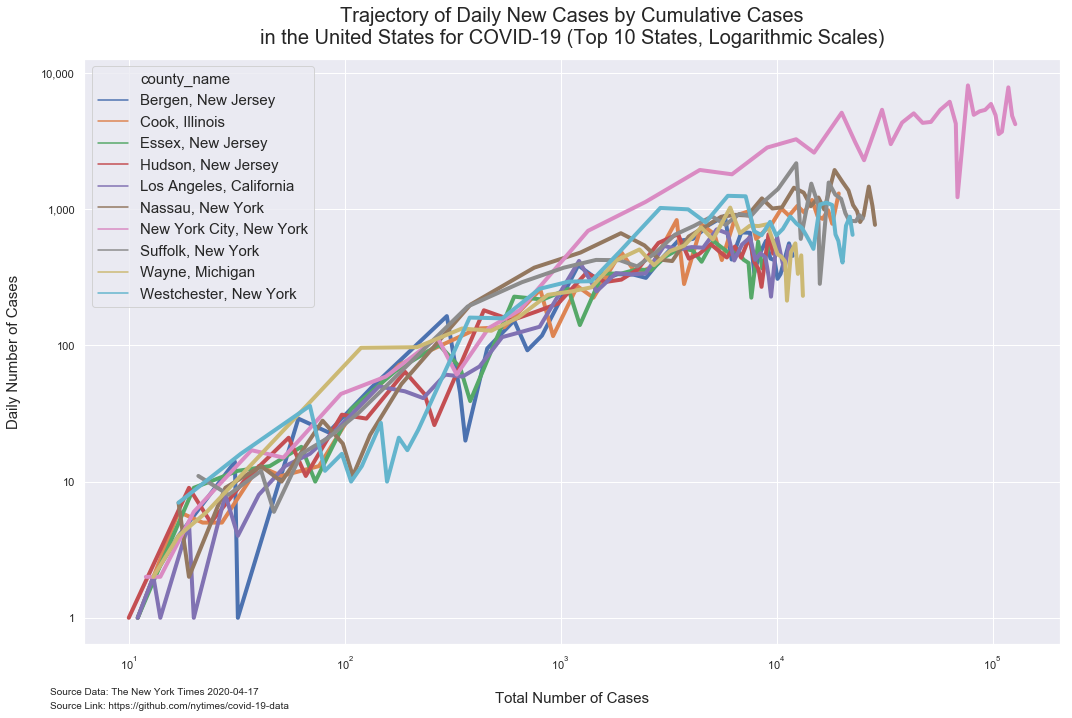

In [98]:
fig, ax1 = plt.subplots(figsize=(15,10))
txt = ('Source Data: The New York Times ' + current_date)
txt2 = ('Source Link: https://github.com/nytimes/covid-19-data')

sns.lineplot(x="cases", y="daily_cases",
             hue="county_name",
             data=trajectory_plot, linewidth=4, ci=False)

ax1.set_yscale('log')
ax1.set_xscale('log')

ax1.xaxis.grid(True, which="major")
ax1.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

ax1.xaxis.labelpad = 20
ax1.yaxis.labelpad = 20

ax1.legend(fontsize=15)
ax1.set_xlabel('Total Number of Cases', fontsize=15)
ax1.set_ylabel('Daily Number of Cases', fontsize=15)
plt.title('Trajectory of Daily New Cases by Cumulative Cases\nin the United States for COVID-19 (Top 10 States, Logarithmic Scales)', pad = 15, fontsize=20)
plt.figtext(0.05, 0.03, txt, wrap=True, horizontalalignment='left', fontsize=10)
plt.figtext(0.05, 0.01, txt2, wrap=True, horizontalalignment='left', fontsize=10)

plt.tight_layout()
#plt.savefig('figures/county-trajectory-daily-plot')

## Weekly

In [99]:
trajectory_plot_weekly = trajectory_plot[['county_name', 'date', 'cases', 'daily_cases']]

In [100]:
trajectory_plot_weekly.head()

county_name       date  cases  daily_cases
223  Bergen, New Jersey 2020-03-11     11          1.0
224  Bergen, New Jersey 2020-03-12     13          2.0
225  Bergen, New Jersey 2020-03-13     17          4.0
226  Bergen, New Jersey 2020-03-14     31         14.0
227  Bergen, New Jersey 2020-03-15     32          1.0

In [101]:
trajectory_plot_weekly = trajectory_plot.set_index('date').groupby('county_name').resample('W').agg({'cases': np.max, 
                                                                                               'daily_cases': np.mean})

In [102]:
trajectory_plot_weekly

cases  daily_cases
county_name           date                          
Bergen, New Jersey    2020-03-15     32     4.400000
                      2020-03-22    457    60.714286
                      2020-03-29   2169   244.571429
                      2020-04-05   6187   574.000000
                      2020-04-12   9784   513.857143
...                                 ...          ...
Westchester, New York 2020-03-22   1873   239.714286
                      2020-03-29   8519   949.428571
                      2020-04-05  13722   743.285714
                      2020-04-12  19313   798.714286
                      2020-04-19  22476   632.600000

[63 rows x 2 columns]

In [103]:
trajectory_plot_weekly.reset_index(inplace=True)

In [104]:
trajectory_plot_weekly.rename(columns={'daily_cases': 'daily_cases_weekly_average'}, inplace=True)

In [105]:
trajectory_plot_weekly

county_name       date  cases  daily_cases_weekly_average
0      Bergen, New Jersey 2020-03-15     32                    4.400000
1      Bergen, New Jersey 2020-03-22    457                   60.714286
2      Bergen, New Jersey 2020-03-29   2169                  244.571429
3      Bergen, New Jersey 2020-04-05   6187                  574.000000
4      Bergen, New Jersey 2020-04-12   9784                  513.857143
..                    ...        ...    ...                         ...
58  Westchester, New York 2020-03-22   1873                  239.714286
59  Westchester, New York 2020-03-29   8519                  949.428571
60  Westchester, New York 2020-04-05  13722                  743.285714
61  Westchester, New York 2020-04-12  19313                  798.714286
62  Westchester, New York 2020-04-19  22476                  632.600000

[63 rows x 4 columns]

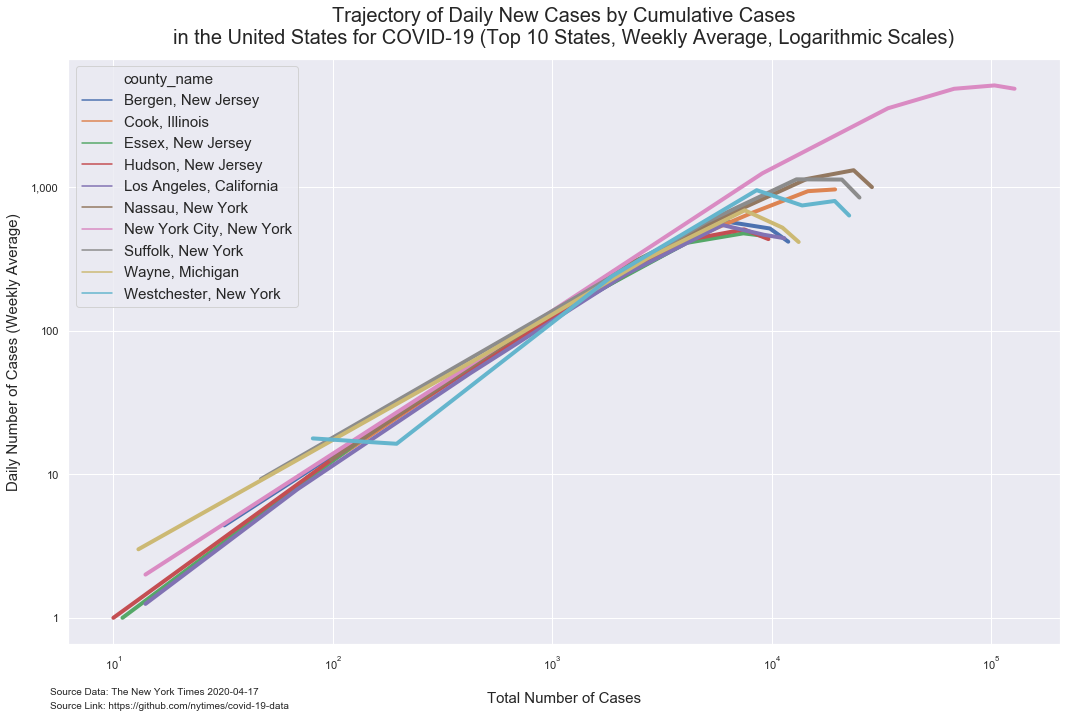

In [106]:
fig, ax1 = plt.subplots(figsize=(15,10))
txt = ('Source Data: The New York Times ' + current_date)
txt2 = ('Source Link: https://github.com/nytimes/covid-19-data')

sns.lineplot(x="cases", y="daily_cases_weekly_average",
             hue="county_name",
             data=trajectory_plot_weekly, linewidth=4)

ax1.set_yscale('log')
ax1.set_xscale('log')

ax1.xaxis.grid(True, which="major")
ax1.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

ax1.xaxis.labelpad = 20
ax1.yaxis.labelpad = 10

ax1.legend(fontsize=15)
ax1.set_xlabel('Total Number of Cases', fontsize=15)
ax1.set_ylabel('Daily Number of Cases (Weekly Average)', fontsize=15)
plt.title('Trajectory of Daily New Cases by Cumulative Cases\nin the United States for COVID-19 (Top 10 States, Weekly Average, Logarithmic Scales)', pad = 15, fontsize=20)
plt.figtext(0.05, 0.03, txt, wrap=True, horizontalalignment='left', fontsize=10)
plt.figtext(0.05, 0.01, txt2, wrap=True, horizontalalignment='left', fontsize=10)

plt.tight_layout()
plt.savefig('figures/county-trajectory-weekly-plot')

In [107]:
trajectory_plot_weekly_scatter = trajectory_plot_weekly.sort_values(by=['date', 'cases'], 
                                              ascending=[False, False]).drop_duplicates(subset ="county_name", 
                                                                                        keep = 'first').reset_index(drop=True)

In [108]:
trajectory_plot_weekly_scatter

county_name       date   cases  daily_cases_weekly_average
0  New York City, New York 2020-04-19  127352                      4828.8
1         Nassau, New York 2020-04-19   28539                       997.2
2        Suffolk, New York 2020-04-19   25035                       843.8
3    Westchester, New York 2020-04-19   22476                       632.6
4           Cook, Illinois 2020-04-19   19391                       961.2
5          Wayne, Michigan 2020-04-19   13233                       413.8
6       Bergen, New Jersey 2020-04-19   11863                       415.8
7  Los Angeles, California 2020-04-19   11391                       439.8
8        Essex, New Jersey 2020-04-19    9672                       452.4
9       Hudson, New Jersey 2020-04-19    9636                       433.4

In [109]:
len(trajectory_plot_weekly_scatter)

10

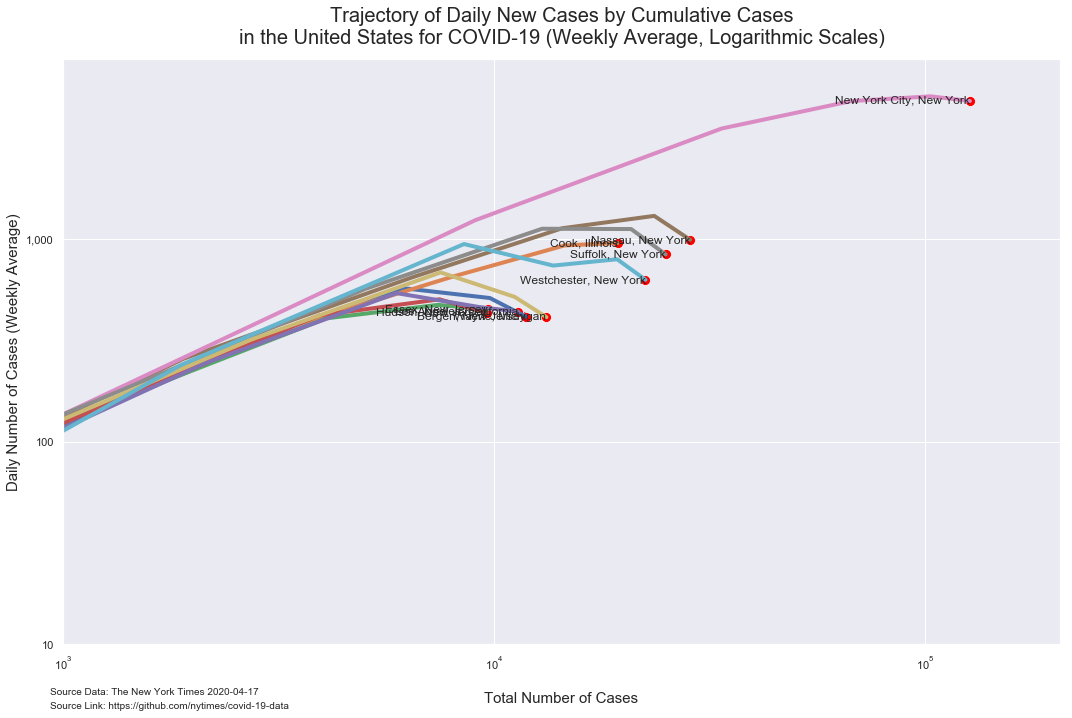

In [110]:
fig, ax1 = plt.subplots(figsize=(15,10))
txt = ('Source Data: The New York Times ' + current_date)
txt2 = ('Source Link: https://github.com/nytimes/covid-19-data')

sns.lineplot(x="cases", y="daily_cases_weekly_average",
             hue="county_name",
             data=trajectory_plot_weekly, linewidth=4)

sns.scatterplot(x="cases", y="daily_cases_weekly_average", 
             data=trajectory_plot_weekly_scatter, s=100, ax=ax1, color='red')


x = trajectory_plot_weekly_scatter.daily_cases_weekly_average
z = trajectory_plot_weekly_scatter.cases
n = trajectory_plot_weekly_scatter.county_name
for i, label in enumerate(n):
    ax1.annotate(label, (z[i], x[i]), fontsize=12,
                 horizontalalignment='right', va='center', clip_on=True)
                
ax1.set_yscale('log')
ax1.set_xscale('log')

ax1.xaxis.grid(True, which="major")
ax1.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

ax1.xaxis.labelpad = 20
ax1.yaxis.labelpad = 5
plt.xlim(1000)
plt.ylim(10)

ax1.legend_.remove()
ax1.set_xlabel('Total Number of Cases', fontsize=15)
ax1.set_ylabel('Daily Number of Cases (Weekly Average)', fontsize=15)
plt.title('Trajectory of Daily New Cases by Cumulative Cases\nin the United States for COVID-19 (Weekly Average, Logarithmic Scales)', pad = 15, fontsize=20)
plt.figtext(0.05, 0.03, txt, wrap=True, horizontalalignment='left', fontsize=10)
plt.figtext(0.05, 0.01, txt2, wrap=True, horizontalalignment='left', fontsize=10)

plt.tight_layout()
plt.savefig('figures/all-counties-trajectory-weekly-plot-labels')

# Trajectory for All Counties

In [111]:
trajectory_all_counties = covid_19_counties_data.sort_values(by=['county_name', 'date','cases'], 
                                ascending=[True, True, True])

In [112]:
trajectory_all_counties

date     county           state     fips  cases  deaths  \
5000  2020-03-19  Abbeville  South Carolina  45001.0      1       0   
5873  2020-03-20  Abbeville  South Carolina  45001.0      1       0   
6877  2020-03-21  Abbeville  South Carolina  45001.0      1       0   
7997  2020-03-22  Abbeville  South Carolina  45001.0      1       0   
9209  2020-03-23  Abbeville  South Carolina  45001.0      1       0   
...          ...        ...             ...      ...    ...     ...   
58911 2020-04-14     Zapata           Texas  48505.0      3       0   
61632 2020-04-15     Zapata           Texas  48505.0      4       0   
64366 2020-04-16     Zapata           Texas  48505.0      4       0   
67115 2020-04-17     Zapata           Texas  48505.0      6       0   
67116 2020-04-17     Zavala           Texas  48507.0      1       0   

                     county_name  
5000   Abbeville, South Carolina  
5873   Abbeville, South Carolina  
6877   Abbeville, South Carolina  
7997   Abbeville, South Carolina  
9209   Abbeville, South Carolina  
...                          ...  
58911              Zapata, Texas  
61632              Zapata, Texas  
64366              Zapata, Texas  
67115              Zapata, Texas  
67116              Zavala, Texas  

[66662 rows x 7 columns]

In [113]:
trajectory_all_counties['daily_cases'] = trajectory_all_counties['cases'].diff()

In [114]:
trajectory_all_counties[150:200]

date county     state     fips  cases  deaths      county_name  \
57276 2020-04-14  Adair      Iowa  19001.0      1       0      Adair, Iowa   
59984 2020-04-15  Adair      Iowa  19001.0      1       0      Adair, Iowa   
62709 2020-04-16  Adair      Iowa  19001.0      1       0      Adair, Iowa   
65445 2020-04-17  Adair      Iowa  19001.0      1       0      Adair, Iowa   
34058 2020-04-05  Adair  Kentucky  21001.0      3       0  Adair, Kentucky   
36520 2020-04-06  Adair  Kentucky  21001.0      3       0  Adair, Kentucky   
39024 2020-04-07  Adair  Kentucky  21001.0      4       1  Adair, Kentucky   
41569 2020-04-08  Adair  Kentucky  21001.0      4       1  Adair, Kentucky   
44137 2020-04-09  Adair  Kentucky  21001.0      9       1  Adair, Kentucky   
46743 2020-04-10  Adair  Kentucky  21001.0     10       1  Adair, Kentucky   
49380 2020-04-11  Adair  Kentucky  21001.0     11       1  Adair, Kentucky   
52046 2020-04-12  Adair  Kentucky  21001.0     43       1  Adair, Kentucky   
54727 2020-04-13  Adair  Kentucky  21001.0     43       1  Adair, Kentucky   
57423 2020-04-14  Adair  Kentucky  21001.0     44       2  Adair, Kentucky   
60132 2020-04-15  Adair  Kentucky  21001.0     45       2  Adair, Kentucky   
62856 2020-04-16  Adair  Kentucky  21001.0     46       3  Adair, Kentucky   
65597 2020-04-17  Adair  Kentucky  21001.0     46       3  Adair, Kentucky   
8892  2020-03-23  Adair  Missouri  29001.0      2       0  Adair, Missouri   
10194 2020-03-24  Adair  Missouri  29001.0      2       0  Adair, Missouri   
11620 2020-03-25  Adair  Missouri  29001.0      2       0  Adair, Missouri   
13223 2020-03-26  Adair  Missouri  29001.0      2       0  Adair, Missouri   
14954 2020-03-27  Adair  Missouri  29001.0      2       0  Adair, Missouri   
16788 2020-03-28  Adair  Missouri  29001.0      2       0  Adair, Missouri   
18722 2020-03-29  Adair  Missouri  29001.0      2       0  Adair, Missouri   
20759 2020-03-30  Adair  Missouri  29001.0      2       0  Adair, Missouri   
22895 2020-03-31  Adair  Missouri  29001.0      2       0  Adair, Missouri   
25090 2020-04-01  Adair  Missouri  29001.0      3       0  Adair, Missouri   
27346 2020-04-02  Adair  Missouri  29001.0      6       0  Adair, Missouri   
29663 2020-04-03  Adair  Missouri  29001.0      8       0  Adair, Missouri   
32044 2020-04-04  Adair  Missouri  29001.0     10       0  Adair, Missouri   
34475 2020-04-05  Adair  Missouri  29001.0     10       0  Adair, Missouri   
36941 2020-04-06  Adair  Missouri  29001.0     10       0  Adair, Missouri   
39451 2020-04-07  Adair  Missouri  29001.0     11       0  Adair, Missouri   
42001 2020-04-08  Adair  Missouri  29001.0     11       0  Adair, Missouri   
44571 2020-04-09  Adair  Missouri  29001.0     11       0  Adair, Missouri   
47179 2020-04-10  Adair  Missouri  29001.0     11       0  Adair, Missouri   
49825 2020-04-11  Adair  Missouri  29001.0     11       0  Adair, Missouri   
52498 2020-04-12  Adair  Missouri  29001.0     11       0  Adair, Missouri   
55180 2020-04-13  Adair  Missouri  29001.0     11       0  Adair, Missouri   
57879 2020-04-14  Adair  Missouri  29001.0     11       0  Adair, Missouri   
60591 2020-04-15  Adair  Missouri  29001.0     12       0  Adair, Missouri   
63317 2020-04-16  Adair  Missouri  29001.0     12       0  Adair, Missouri   
66059 2020-04-17  Adair  Missouri  29001.0     12       0  Adair, Missouri   
11917 2020-03-25  Adair  Oklahoma  40001.0      2       0  Adair, Oklahoma   
13537 2020-03-26  Adair  Oklahoma  40001.0      2       0  Adair, Oklahoma   
15285 2020-03-27  Adair  Oklahoma  40001.0      3       0  Adair, Oklahoma   
17141 2020-03-28  Adair  Oklahoma  40001.0      3       0  Adair, Oklahoma   
19089 2020-03-29  Adair  Oklahoma  40001.0      4       0  Adair, Oklahoma   
21146 2020-03-30  Adair  Oklahoma  40001.0      4       0  Adair, Oklahoma   
23296 2020-03-31  Adair  Oklahoma  40001.0      4       0  Adair, Oklahoma   

       daily_cases  
57276       

In [115]:
trajectory_all_counties['daily_cases'].loc[trajectory_all_counties.daily_cases < 0] = trajectory_all_counties.cases
trajectory_all_counties['daily_cases'].loc[trajectory_all_counties.daily_cases.isnull()] = trajectory_all_counties.cases

In [116]:
trajectory_all_counties[:50]

date     county           state     fips  cases  deaths  \
5000  2020-03-19  Abbeville  South Carolina  45001.0      1       0   
5873  2020-03-20  Abbeville  South Carolina  45001.0      1       0   
6877  2020-03-21  Abbeville  South Carolina  45001.0      1       0   
7997  2020-03-22  Abbeville  South Carolina  45001.0      1       0   
9209  2020-03-23  Abbeville  South Carolina  45001.0      1       0   
10539 2020-03-24  Abbeville  South Carolina  45001.0      1       0   
12015 2020-03-25  Abbeville  South Carolina  45001.0      3       0   
13647 2020-03-26  Abbeville  South Carolina  45001.0      4       0   
15404 2020-03-27  Abbeville  South Carolina  45001.0      4       0   
17268 2020-03-28  Abbeville  South Carolina  45001.0      4       0   
19222 2020-03-29  Abbeville  South Carolina  45001.0      4       0   
21283 2020-03-30  Abbeville  South Carolina  45001.0      3       0   
23436 2020-03-31  Abbeville  South Carolina  45001.0      4       0   
25643 2020-04-01  Abbeville  South Carolina  45001.0      4       0   
27916 2020-04-02  Abbeville  South Carolina  45001.0      6       0   
30251 2020-04-03  Abbeville  South Carolina  45001.0      6       0   
32644 2020-04-04  Abbeville  South Carolina  45001.0      6       0   
35083 2020-04-05  Abbeville  South Carolina  45001.0      6       0   
37561 2020-04-06  Abbeville  South Carolina  45001.0      6       0   
40081 2020-04-07  Abbeville  South Carolina  45001.0      5       0   
42637 2020-04-08  Abbeville  South Carolina  45001.0      6       0   
45216 2020-04-09  Abbeville  South Carolina  45001.0      7       0   
47833 2020-04-10  Abbeville  South Carolina  45001.0      7       0   
50489 2020-04-11  Abbeville  South Carolina  45001.0      9       0   
53162 2020-04-12  Abbeville  South Carolina  45001.0      9       0   
55849 2020-04-13  Abbeville  South Carolina  45001.0      9       0   
58552 2020-04-14  Abbeville  South Carolina  45001.0      9       0   
61270 2020-04-15  Abbeville  South Carolina  45001.0     10       0   
63998 2020-04-16  Abbeville  South Carolina  45001.0     10       0   
66746 2020-04-17  Abbeville  South Carolina  45001.0     10       0   
7518  2020-03-22     Acadia       Louisiana  22001.0      1       0   
8681  2020-03-23     Acadia       Louisiana  22001.0      1       0   
9973  2020-03-24     Acadia       Louisiana  22001.0      2       0   
11381 2020-03-25     Acadia       Louisiana  22001.0      2       0   
12963 2020-03-26     Acadia       Louisiana  22001.0      3       0   
14680 2020-03-27     Acadia       Louisiana  22001.0      8       1   
16507 2020-03-28     Acadia       Louisiana  22001.0      9       1   
18432 2020-03-29     Acadia       Louisiana  22001.0      9       1   
20461 2020-03-30     Acadia       Louisiana  22001.0     11       1   
22586 2020-03-31     Acadia       Louisiana  22001.0     39       1   
24774 2020-04-01     Acadia       Louisiana  22001.0     47       1   
27029 2020-04-02     Acadia       Louisiana  22001.0     61       1   
29341 2020-04-03     Acadia       Louisiana  22001.0     72       1   
31721 2020-04-04     Acadia       Louisiana  22001.0     65       2   
34147 2020-04-05     Acadia       Louisiana  22001.0     75       2   
36609 2020-04-06     Acadia       Louisiana  22001.0     79       2   
39115 2020-04-07     Acadia       Louisiana  22001.0     82       2   
41664 2020-04-08     Acadia       Louisiana  22001.0     86       2   
44233 2020-04-09     Acadia       Louisiana  22001.0     89       3   
46839 2020-04-10     Acadia       Louisiana  22001.0     94       4   

                     county_name  daily_cases  
5000   Abbeville, South Carolina          1.0  
5873   Abbeville, South Carolina          0.0  
6877   Abbeville, South Carolina          0.0  
7997   Abbeville, South Carolina          0.0  
9209   Abbeville, South Carolina          0.0  
10539  Abbeville, South Carolina          0.0  
12015  Abbeville, South Carolina          2.0  
13647 

In [117]:
trajectory_all_counties = trajectory_all_counties.set_index('date').groupby('county_name').resample('W').agg({'cases': np.max, 
                                                                                                    'daily_cases': np.mean})
trajectory_all_counties.reset_index(inplace=True)
trajectory_all_counties.rename(columns={'daily_cases': 'daily_cases_week_avg'}, inplace=True)

In [118]:
trajectory_all_counties.head()

county_name       date  cases  daily_cases_week_avg
0  Abbeville, South Carolina 2020-03-22    1.0              0.250000
1  Abbeville, South Carolina 2020-03-29    4.0              0.428571
2  Abbeville, South Carolina 2020-04-05    6.0              0.857143
3  Abbeville, South Carolina 2020-04-12    9.0              1.285714
4  Abbeville, South Carolina 2020-04-19   10.0              0.200000

In [119]:
temp_fill_zeros = trajectory_all_counties.sort_values(by=['county_name', 'date','cases'], 
                                                 ascending=[True, True, True])

temp_fill_zeros['cases'].loc[temp_fill_zeros.cases < 1] = 1
temp_fill_zeros['daily_cases_week_avg'].loc[temp_fill_zeros.daily_cases_week_avg < 1] = 1

temp_fill_zeros

county_name       date  cases  daily_cases_week_avg
0      Abbeville, South Carolina 2020-03-22    1.0              1.000000
1      Abbeville, South Carolina 2020-03-29    4.0              1.000000
2      Abbeville, South Carolina 2020-04-05    6.0              1.000000
3      Abbeville, South Carolina 2020-04-12    9.0              1.285714
4      Abbeville, South Carolina 2020-04-19   10.0              1.000000
...                          ...        ...    ...                   ...
11502             Yuma, Colorado 2020-04-12    2.0              1.000000
11503             Yuma, Colorado 2020-04-19    2.0              1.000000
11504              Zapata, Texas 2020-04-12    3.0              1.000000
11505              Zapata, Texas 2020-04-19    6.0              1.000000
11506              Zavala, Texas 2020-04-19    1.0              1.000000

[11507 rows x 4 columns]

In [120]:
temp_fill_zeros.loc[temp_fill_zeros.cases.isnull() == True]

county_name       date  cases  daily_cases_week_avg
2800       Decatur, Tennessee 2020-04-05    NaN                   NaN
4964  Jackson, North Carolina 2020-04-12    NaN                   NaN
8729          Rhea, Tennessee 2020-04-12    NaN                   NaN

In [121]:
temp_fill_zeros.dropna()

county_name       date  cases  daily_cases_week_avg
0      Abbeville, South Carolina 2020-03-22    1.0              1.000000
1      Abbeville, South Carolina 2020-03-29    4.0              1.000000
2      Abbeville, South Carolina 2020-04-05    6.0              1.000000
3      Abbeville, South Carolina 2020-04-12    9.0              1.285714
4      Abbeville, South Carolina 2020-04-19   10.0              1.000000
...                          ...        ...    ...                   ...
11502             Yuma, Colorado 2020-04-12    2.0              1.000000
11503             Yuma, Colorado 2020-04-19    2.0              1.000000
11504              Zapata, Texas 2020-04-12    3.0              1.000000
11505              Zapata, Texas 2020-04-19    6.0              1.000000
11506              Zavala, Texas 2020-04-19    1.0              1.000000

[11504 rows x 4 columns]

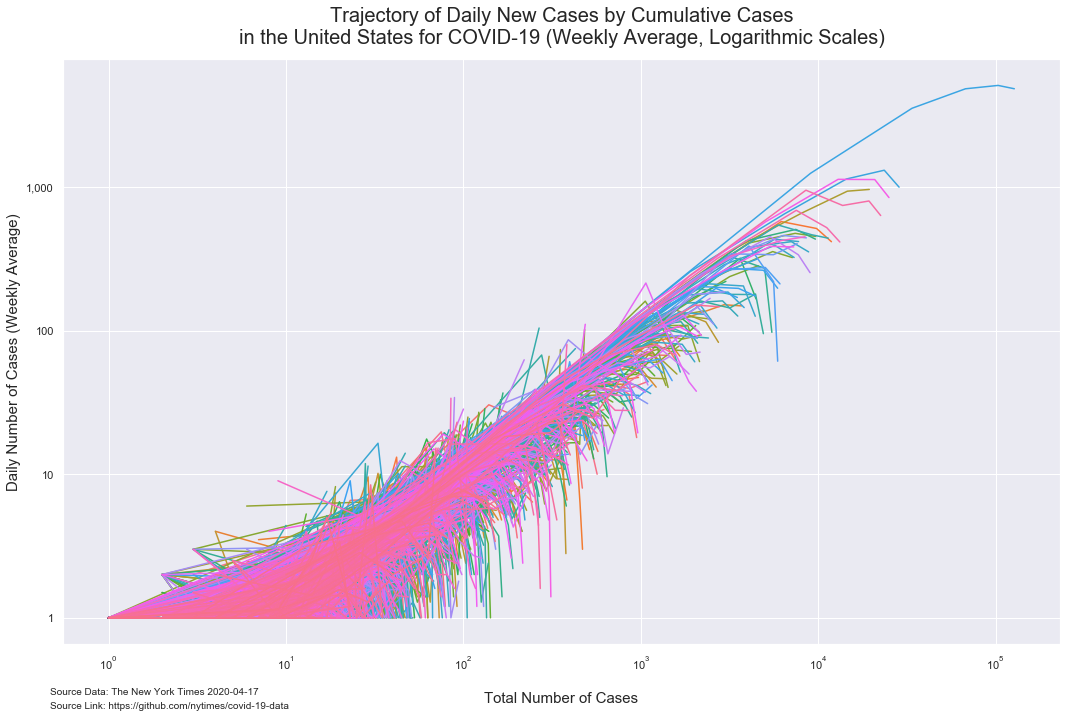

In [122]:
fig, ax1 = plt.subplots(figsize=(15,10))
txt = ('Source Data: The New York Times ' + current_date)
txt2 = ('Source Link: https://github.com/nytimes/covid-19-data')

sns.lineplot(x="cases", y="daily_cases_week_avg",
             hue="county_name",
             data=temp_fill_zeros, ci=False)
                
ax1.set_yscale('log')
ax1.set_xscale('log')

ax1.xaxis.grid(True, which="major")
ax1.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

ax1.xaxis.labelpad = 20
ax1.yaxis.labelpad = 5

ax1.legend_.remove()
ax1.set_xlabel('Total Number of Cases', fontsize=15)
ax1.set_ylabel('Daily Number of Cases (Weekly Average)', fontsize=15)
plt.title('Trajectory of Daily New Cases by Cumulative Cases\nin the United States for COVID-19 (Weekly Average, Logarithmic Scales)', pad = 15, fontsize=20)
plt.figtext(0.05, 0.03, txt, wrap=True, horizontalalignment='left', fontsize=10)
plt.figtext(0.05, 0.01, txt2, wrap=True, horizontalalignment='left', fontsize=10)

plt.tight_layout()
plt.savefig('figures/all-counties-trajectory-weekly-plot')

# Timeseries for USA

In [123]:
g = covid_19_counties_data.groupby('date')['cases'].sum().reset_index()

g.set_index('date', drop=False, inplace=True)

g.index = pd.to_datetime(g.index, infer_datetime_format=True)

In [124]:
g.index.dtype

dtype('<M8[ns]')

In [125]:
g.head()

date  cases
date                        
2020-01-21 2020-01-21      1
2020-01-22 2020-01-22      1
2020-01-23 2020-01-23      1
2020-01-24 2020-01-24      2
2020-01-25 2020-01-25      3

In [126]:
g.tail()

date   cases
date                         
2020-04-13 2020-04-13  573983
2020-04-14 2020-04-14  600732
2020-04-15 2020-04-15  630859
2020-04-16 2020-04-16  662292
2020-04-17 2020-04-17  693677

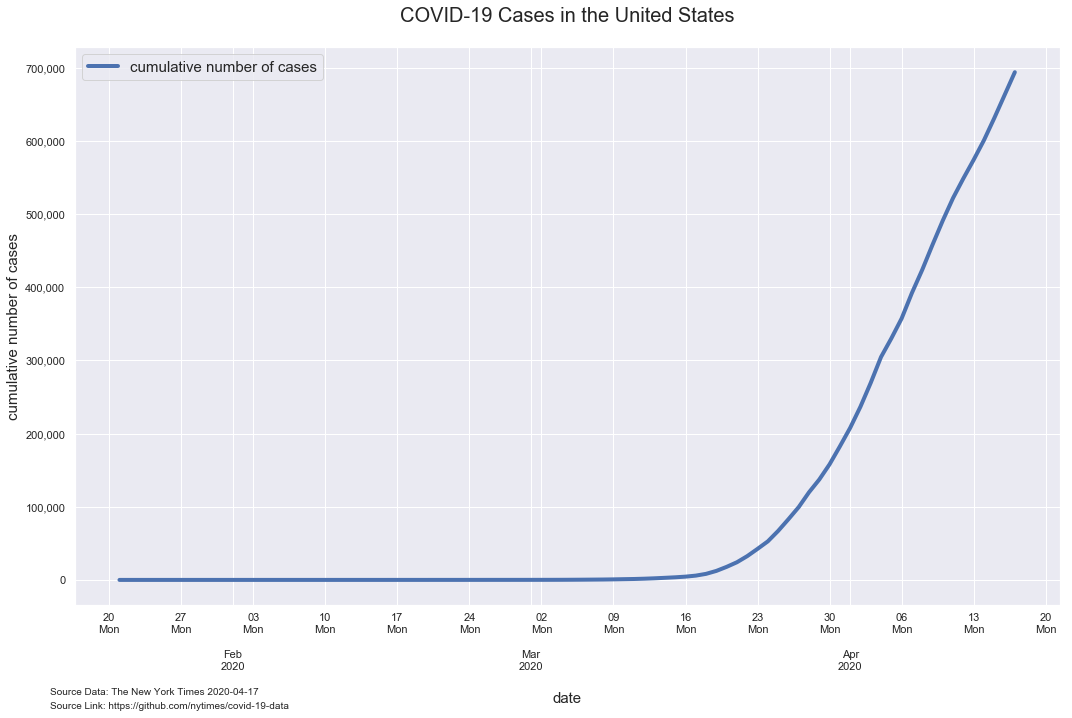

In [127]:
fig, ax1 = plt.subplots(figsize=(15,10))
txt = ('Source Data: The New York Times ' + current_date)
txt2 = ('Source Link: https://github.com/nytimes/covid-19-data')

ax1.plot(g['cases'], linewidth=4)

ax1.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax1.xaxis.set_minor_locator(dates.WeekdayLocator(byweekday=(0), interval=1))
ax1.xaxis.set_minor_formatter(dates.DateFormatter('%d\n%a'))
ax1.xaxis.grid(True, which="major")
ax1.xaxis.set_major_locator(dates.MonthLocator())
ax1.xaxis.set_major_formatter(dates.DateFormatter('\n\n\n%b\n%Y'))
ax1.set_xlabel('date', fontsize=15, labelpad = 20)
ax1.set_ylabel('cumulative number of cases', fontsize=15)

ax1.grid(True)
ax1.grid(which='minor')

ax1.legend(['cumulative number of cases'], loc=2, fontsize=15)
plt.title('COVID-19 Cases in the United States', pad = 25, fontsize=20)
plt.figtext(0.05, 0.03, txt, wrap=True, horizontalalignment='left', fontsize=10)
plt.figtext(0.05, 0.01, txt2, wrap=True, horizontalalignment='left', fontsize=10)

plt.tight_layout()
plt.savefig('figures/counties-linear')

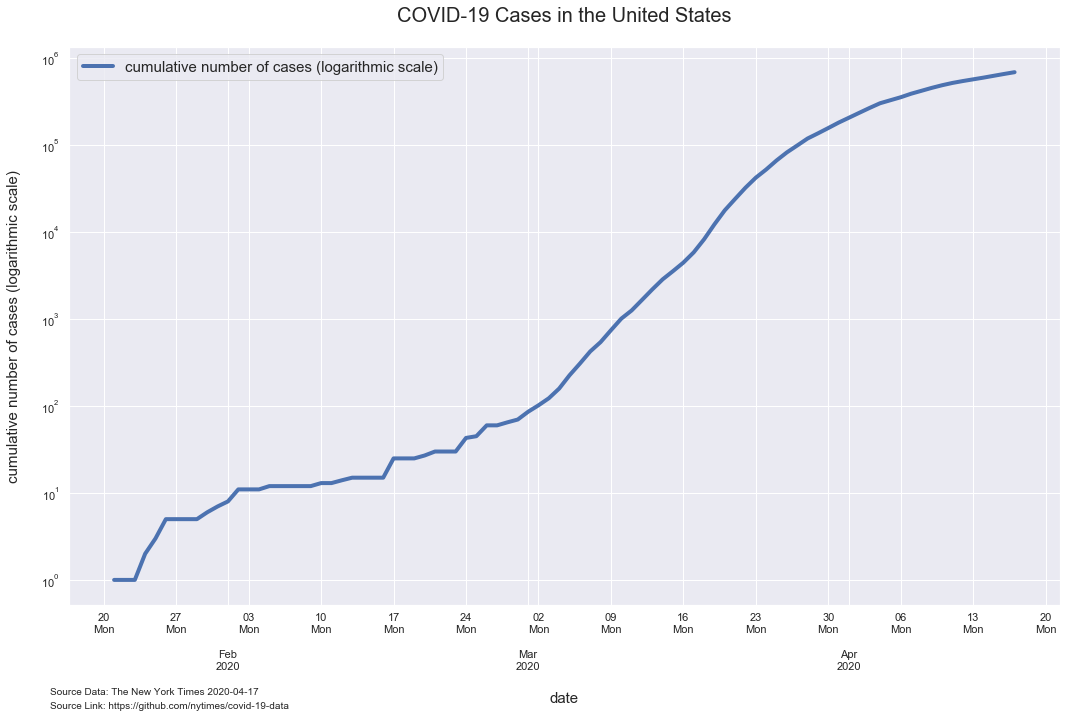

In [128]:
fig, ax2 = plt.subplots(figsize=(15,10))
txt = ('Source Data: The New York Times ' + current_date)
txt2 = ('Source Link: https://github.com/nytimes/covid-19-data')

ax2.plot(g['cases'], linewidth=4)

ax2.xaxis.set_minor_locator(dates.WeekdayLocator(byweekday=(0), interval=1))
ax2.xaxis.set_minor_formatter(dates.DateFormatter('%d\n%a'))
ax2.xaxis.grid(True, which="major")
ax2.xaxis.set_major_locator(dates.MonthLocator())
ax2.xaxis.set_major_formatter(dates.DateFormatter('\n\n\n%b\n%Y'))
ax2.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

ax2.set_xlabel('date', fontsize=15, labelpad = 20)
ax2.set_ylabel('cumulative number of cases (logarithmic scale)', fontsize=15, labelpad = 20)

ax2.grid(True)
ax2.grid(which='minor', axis='x')

ax2.legend(['cumulative number of cases (logarithmic scale)'], loc=0, fontsize=15)
plt.title('COVID-19 Cases in the United States', pad = 25, fontsize=20)
plt.figtext(0.05, 0.03, txt, wrap=True, horizontalalignment='left', fontsize=10)
plt.figtext(0.05, 0.01, txt2, wrap=True, horizontalalignment='left', fontsize=10)

ax2.set_yscale('log')
plt.tight_layout()
plt.savefig('figures/counties-log')

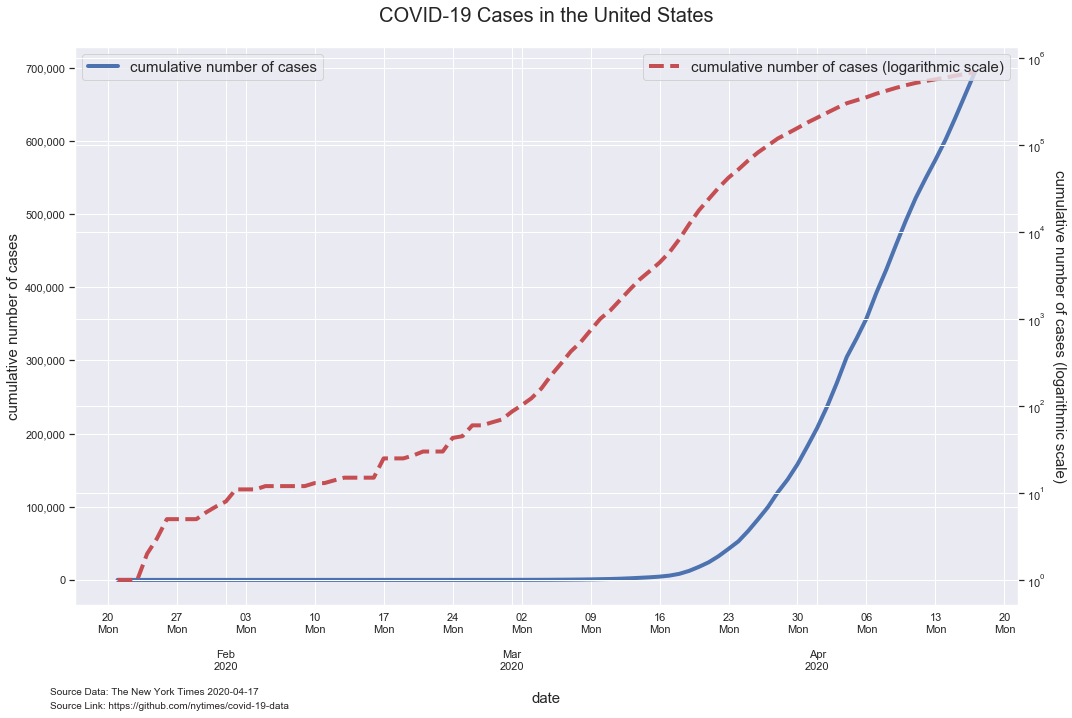

In [129]:
fig, ax1 = plt.subplots(figsize=(15,10))
txt = ('Source Data: The New York Times ' + current_date)
txt2 = ('Source Link: https://github.com/nytimes/covid-19-data')

# Plot 1
ax1.plot(g['cases'], linewidth=4)

# Plot 2
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.plot(g['cases'], linewidth=4, color='r', linestyle='dashed')

ax1.xaxis.set_minor_locator(dates.WeekdayLocator(byweekday=(0),interval=1))
ax1.xaxis.set_minor_formatter(dates.DateFormatter('%d\n%a'))
ax1.xaxis.grid(True, which="major")
ax1.xaxis.set_major_locator(dates.MonthLocator())
ax1.xaxis.set_major_formatter(dates.DateFormatter('\n\n\n%b\n%Y'))
ax2.xaxis.set_minor_locator(dates.WeekdayLocator(byweekday=(0), interval=1))

ax1.set_ylabel('cumulative number of cases', fontsize=15)
ax1.set_xlabel('date', fontsize=15, labelpad = 20)
ax1.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax2.set_ylabel('cumulative number of cases (logarithmic scale)', fontsize=15, rotation = 270, labelpad = 20)
ax2.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax2.get_yaxis().set_visible(True)
ax2.set_yscale('log')

ax1.grid(True)
ax1.grid(which='minor')
ax2.tick_params(axis='both', which='minor', length=0)
plt.setp(ax2.get_yticklabels(), visible=True)

ax1.legend(['cumulative number of cases'], loc=2, fontsize=15)
ax2.legend(['cumulative number of cases (logarithmic scale)'], loc=1, fontsize=15)
plt.title('COVID-19 Cases in the United States', pad = 25, fontsize=20)
plt.figtext(0.05, 0.03, txt, wrap=True, horizontalalignment='left', fontsize=10)
plt.figtext(0.05, 0.01, txt2, wrap=True, horizontalalignment='left', fontsize=10)

plt.tight_layout()
plt.savefig('figures/counties-timeseries-overlay')

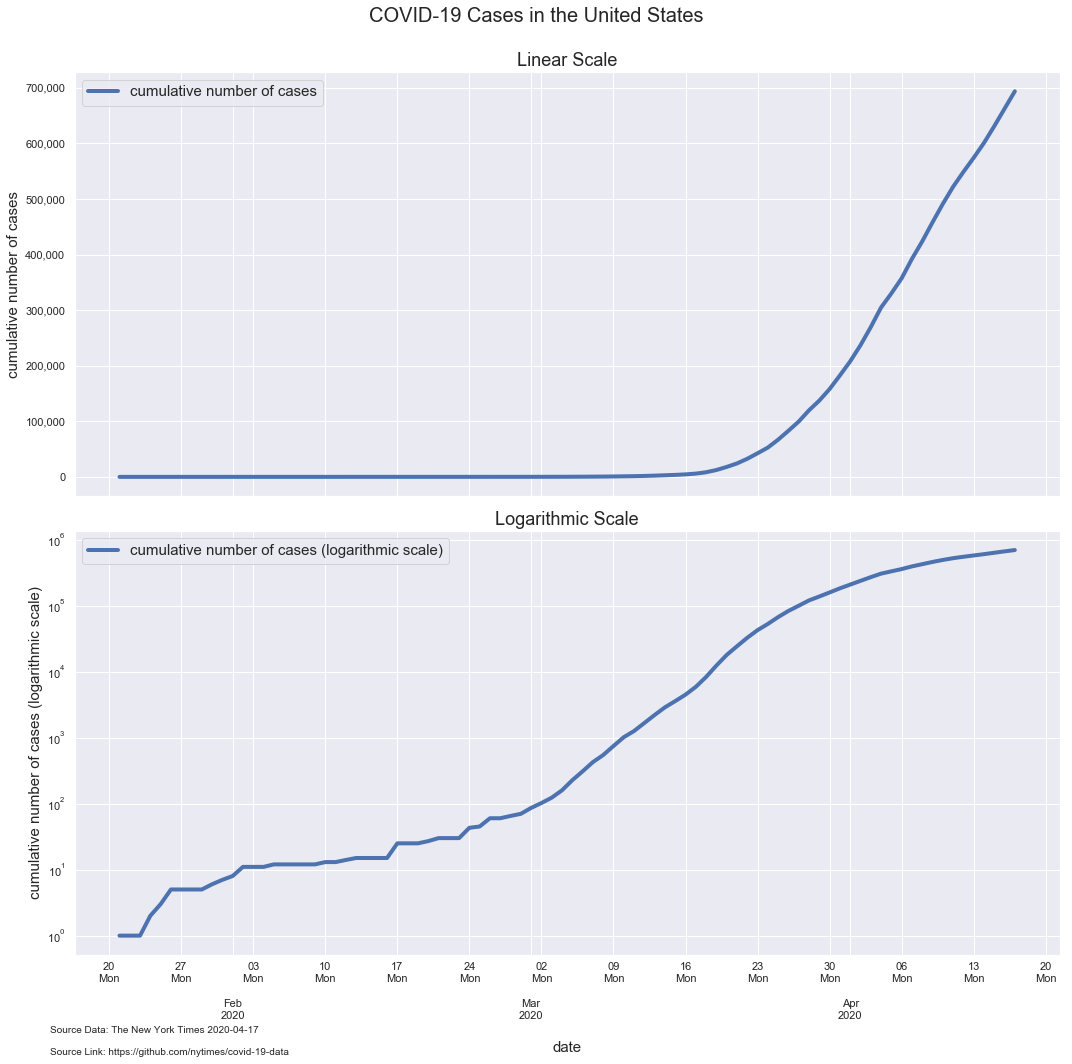

In [130]:
fig, [ax1, ax2] = plt.subplots(2, 1, sharex=True, figsize=(15,15))
fig.suptitle('COVID-19 Cases in the United States', fontsize=20)
txt = ('Source Data: The New York Times ' + current_date)
txt2 = ('Source Link: https://github.com/nytimes/covid-19-data')

# Plot 1
ax1.plot(g['cases'], linewidth=4)
ax1.xaxis.set_minor_locator(dates.WeekdayLocator(byweekday=(0), interval=1))
ax1.set_ylabel('cumulative number of cases', fontsize=15)
ax1.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax1.xaxis.set_minor_formatter(dates.DateFormatter('%d\n%a'))
ax1.xaxis.grid(True, which="major")
ax1.xaxis.set_major_locator(dates.MonthLocator())
ax1.xaxis.set_major_formatter(dates.DateFormatter('\n\n\n%b\n%Y'))

# Formatting Grid
ax1.grid(True)
ax1.grid(which='minor')

# Plot 2
ax2.plot(g['cases'], linewidth=4)
ax2.xaxis.set_minor_locator(dates.WeekdayLocator(byweekday=(0), interval=1))
ax2.set_ylabel('cumulative number of cases (logarithmic scale)', fontsize=15)
ax2.set_xlabel('date', fontsize=15, labelpad = 20)
ax2.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax2.xaxis.set_minor_formatter(dates.DateFormatter('%d\n%a'))
ax2.xaxis.grid(True, which="major")
ax2.xaxis.set_major_locator(dates.MonthLocator())
ax2.xaxis.set_major_formatter(dates.DateFormatter('\n\n\n%b\n%Y'))

# Formatting Grid
ax2.grid(True)
ax2.grid(which='minor', axis='x')

# Formatting Figure
ax1.legend(['cumulative number of cases'], loc=2, fontsize=15)
ax2.legend(['cumulative number of cases (logarithmic scale)'], loc=2, fontsize=15)
ax1.set_title('Linear Scale', fontsize=18)
ax2.set_title('Logarithmic Scale', fontsize=18)
ax2.set_yscale('log')

plt.figtext(0.05, 0.03, txt, wrap=True, horizontalalignment='left', fontsize=10)
plt.figtext(0.05, 0.01, txt2, wrap=True, horizontalalignment='left', fontsize=10)

plt.tight_layout()
fig.subplots_adjust(top=0.92)
plt.savefig('figures/counties-timeseries-2-subplots')

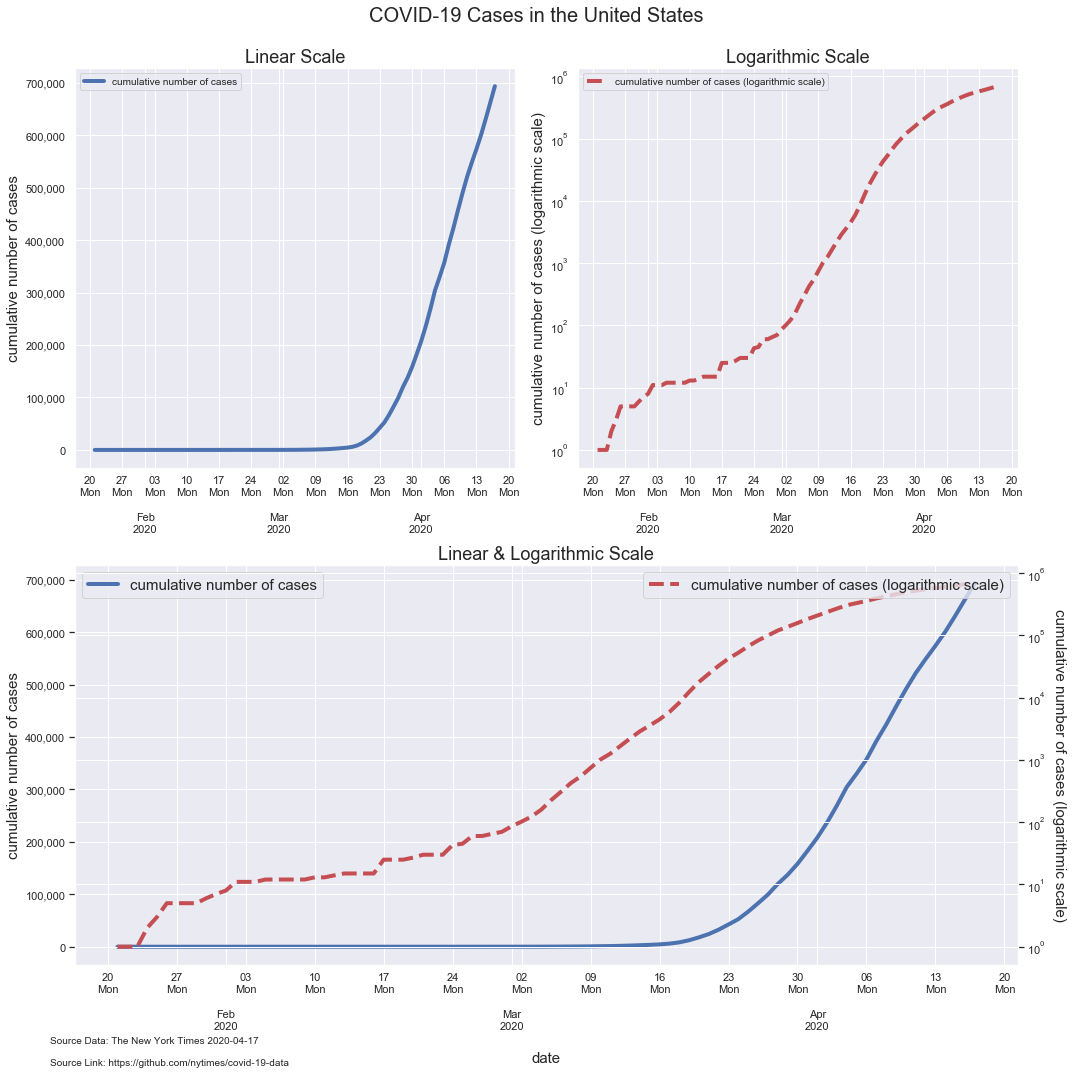

In [131]:
fig, [ax1, ax2, ax3, ax3_1] = plt.subplots(4, 1, sharex=True, figsize=(15,15))
fig.suptitle('COVID-19 Cases in the United States', y = .99, fontsize=20)
txt = ('Source Data: The New York Times ' + current_date)
txt2 = ('Source Link: https://github.com/nytimes/covid-19-data')

# Plot 1
ax3 = plt.subplot(212)
ax3.plot(g['cases'], linewidth=4)
ax3.xaxis.set_minor_locator(dates.WeekdayLocator(byweekday=(0), interval=1))
ax3.set_xlabel('Date', fontsize=15, labelpad = 20)
ax3.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

ax3_1 = ax3.twinx()  # instantiate a second axes that shares the same x-axis
ax3_1.plot(g['cases'], linewidth=4, color='r', linestyle='dashed')
ax3_1.xaxis.set_minor_locator(dates.WeekdayLocator(byweekday=(0), interval=1))
ax3_1.xaxis.grid(True, which="major")
ax3_1.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax3_1.set_yscale('log')

ax3.xaxis.set_minor_formatter(dates.DateFormatter('%d\n%a'))
ax3.xaxis.grid(True, which="major")
ax3.xaxis.set_major_locator(dates.MonthLocator())
ax3.xaxis.set_major_formatter(dates.DateFormatter('\n\n\n%b\n%Y'))

# Plot 2
ax1 = plt.subplot(221)
ax1.plot(g['cases'], linewidth=4)
ax1.xaxis.set_minor_locator(dates.WeekdayLocator(byweekday=(0), interval=1))
ax1.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax1.xaxis.set_minor_formatter(dates.DateFormatter('%d\n%a'))
ax1.xaxis.grid(True, which="major")
ax1.xaxis.set_major_locator(dates.MonthLocator())
ax1.xaxis.set_major_formatter(dates.DateFormatter('\n\n\n%b\n%Y'))


# Plot 3
ax2 = plt.subplot(222)
ax2.plot(g['cases'], linewidth=4, color='r', linestyle='dashed')
ax2.xaxis.set_minor_locator(dates.WeekdayLocator(byweekday=(0), interval=1))

ax2.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax2.xaxis.set_minor_formatter(dates.DateFormatter('%d\n%a'))
ax2.xaxis.grid(True, which="major")
ax2.xaxis.set_major_locator(dates.MonthLocator())
ax2.xaxis.set_major_formatter(dates.DateFormatter('\n\n\n%b\n%Y'))

# Formatting Grid
ax1.grid(True)
ax1.grid(which='minor')
ax2.grid(True)
ax2.grid(which='minor', axis='x')
ax3.grid(True)
ax3.grid(which='minor')
ax3_1.grid(True)
ax3_1.grid(which='minor', axis='x')
ax3_1.tick_params(axis='both', which='minor', length=0)

# Setting Labels
ax1.set_ylabel('cumulative number of cases', fontsize=15)
ax2.set_ylabel('cumulative number of cases (logarithmic scale)', fontsize=15)
ax3.set_ylabel('cumulative number of cases', fontsize=15)
ax3.set_xlabel('date', fontsize=15, labelpad = 20)
ax3_1.set_ylabel('cumulative number of cases (logarithmic scale)', fontsize=15, rotation = 270, labelpad = 20)
ax2.get_yaxis().set_visible(True)
ax2.set_yscale('log')
ax2.get_yaxis().set_visible(True)
ax3_1.get_yaxis().set_visible(True)
ax3_1.set_yscale('log')
ax3_1.get_yaxis().set_visible(True)

# Setting Titles
ax1.set_title('\n\nLinear Scale', fontsize=18)
ax2.set_title('Logarithmic Scale', fontsize=18)
ax3.set_title('Linear & Logarithmic Scale', fontsize=18)

# Setting Legends
ax1.legend(['cumulative number of cases'], loc=2, fontsize=10)
ax2.legend(['cumulative number of cases (logarithmic scale)'], loc=2, fontsize=10)
ax3.legend(['cumulative number of cases'], loc=2, fontsize=15)
ax3_1.legend(['cumulative number of cases (logarithmic scale)'], loc=1, fontsize=15)

plt.figtext(0.05, 0.03, txt, wrap=True, horizontalalignment='left', fontsize=10)
plt.figtext(0.05, 0.01, txt2, wrap=True, horizontalalignment='left', fontsize=10)

plt.tight_layout()
plt.savefig('figures/counties-3-subplots')

# Country Trajectory Plot

In [132]:
g['daily_cases'] = g['cases'].diff()

In [133]:
g.head(20)

date  cases  daily_cases
date                                     
2020-01-21 2020-01-21      1          NaN
2020-01-22 2020-01-22      1          0.0
2020-01-23 2020-01-23      1          0.0
2020-01-24 2020-01-24      2          1.0
2020-01-25 2020-01-25      3          1.0
2020-01-26 2020-01-26      5          2.0
2020-01-27 2020-01-27      5          0.0
2020-01-28 2020-01-28      5          0.0
2020-01-29 2020-01-29      5          0.0
2020-01-30 2020-01-30      6          1.0
2020-01-31 2020-01-31      7          1.0
2020-02-01 2020-02-01      8          1.0
2020-02-02 2020-02-02     11          3.0
2020-02-03 2020-02-03     11          0.0
2020-02-04 2020-02-04     11          0.0
2020-02-05 2020-02-05     12          1.0
2020-02-06 2020-02-06     12          0.0
2020-02-07 2020-02-07     12          0.0
2020-02-08 2020-02-08     12          0.0
2020-02-09 2020-02-09     12          0.0

In [134]:
g['daily_cases'].loc[g.daily_cases < 0] = g.cases
g['daily_cases'].loc[g.daily_cases.isnull()] = g.cases

In [135]:
g[:50]

date  cases  daily_cases
date                                     
2020-01-21 2020-01-21      1          1.0
2020-01-22 2020-01-22      1          0.0
2020-01-23 2020-01-23      1          0.0
2020-01-24 2020-01-24      2          1.0
2020-01-25 2020-01-25      3          1.0
2020-01-26 2020-01-26      5          2.0
2020-01-27 2020-01-27      5          0.0
2020-01-28 2020-01-28      5          0.0
2020-01-29 2020-01-29      5          0.0
2020-01-30 2020-01-30      6          1.0
2020-01-31 2020-01-31      7          1.0
2020-02-01 2020-02-01      8          1.0
2020-02-02 2020-02-02     11          3.0
2020-02-03 2020-02-03     11          0.0
2020-02-04 2020-02-04     11          0.0
2020-02-05 2020-02-05     12          1.0
2020-02-06 2020-02-06     12          0.0
2020-02-07 2020-02-07     12          0.0
2020-02-08 2020-02-08     12          0.0
2020-02-09 2020-02-09     12          0.0
2020-02-10 2020-02-10     13          1.0
2020-02-11 2020-02-11     13          0.0
2020-02-12 2020-02-12     14          1.0
2020-02-13 2020-02-13     15          1.0
2020-02-14 2020-02-14     15          0.0
2020-02-15 2020-02-15     15          0.0
2020-02-16 2020-02-16     15          0.0
2020-02-17 2020-02-17     25         10.0
2020-02-18 2020-02-18     25          0.0
2020-02-19 2020-02-19     25          0.0
2020-02-20 2020-02-20     27          2.0
2020-02-21 2020-02-21     30          3.0
2020-02-22 2020-02-22     30          0.0
2020-02-23 2020-02-23     30          0.0
2020-02-24 2020-02-24     43         13.0
2020-02-25 2020-02-25     45          2.0
2020-02-26 2020-02-26     60         15.0
2020-02-27 2020-02-27     60          0.0
2020-02-28 2020-02-28     65          5.0
2020-02-29 2020-02-29     70          5.0
2020-03-01 2020-03-01     86         16.0
2020-03-02 2020-03-02    102         16.0
2020-03-03 2020-03-03    123         21.0
2020-03-04 2020-03-04    159         36.0
2020-03-05 2020-03-05    226         67.0
2020-03-06 2020-03-06    308         82.0
2020-03-07 2020-03-07    425        117.0
2020-03-08 2020-03-08    544        119.0
2020-03-09 2020-03-09    745        201.0
2020-03-10 2020-03-10   1013        268.0

In [136]:
g_weekly = g.set_index('date').resample('W').agg({'cases': np.max, 'daily_cases': np.mean})

In [137]:
g_weekly

cases   daily_cases
date                            
2020-01-26       5      0.833333
2020-02-02      11      0.857143
2020-02-09      12      0.142857
2020-02-16      15      0.428571
2020-02-23      30      2.142857
2020-03-01      86      8.000000
2020-03-08     544     65.428571
2020-03-15    3570    432.285714
2020-03-22   32521   4135.857143
2020-03-29  137191  14952.857143
2020-04-05  329966  27539.285714
2020-04-12  548539  31224.714286
2020-04-19  693677  29027.600000

In [138]:
g_weekly.reset_index(inplace=True)
g_weekly.rename(columns={'cases_diff': 'cases_daily_week_avg'}, inplace=True)

In [139]:
g_weekly

date   cases   daily_cases
0  2020-01-26       5      0.833333
1  2020-02-02      11      0.857143
2  2020-02-09      12      0.142857
3  2020-02-16      15      0.428571
4  2020-02-23      30      2.142857
5  2020-03-01      86      8.000000
6  2020-03-08     544     65.428571
7  2020-03-15    3570    432.285714
8  2020-03-22   32521   4135.857143
9  2020-03-29  137191  14952.857143
10 2020-04-05  329966  27539.285714
11 2020-04-12  548539  31224.714286
12 2020-04-19  693677  29027.600000

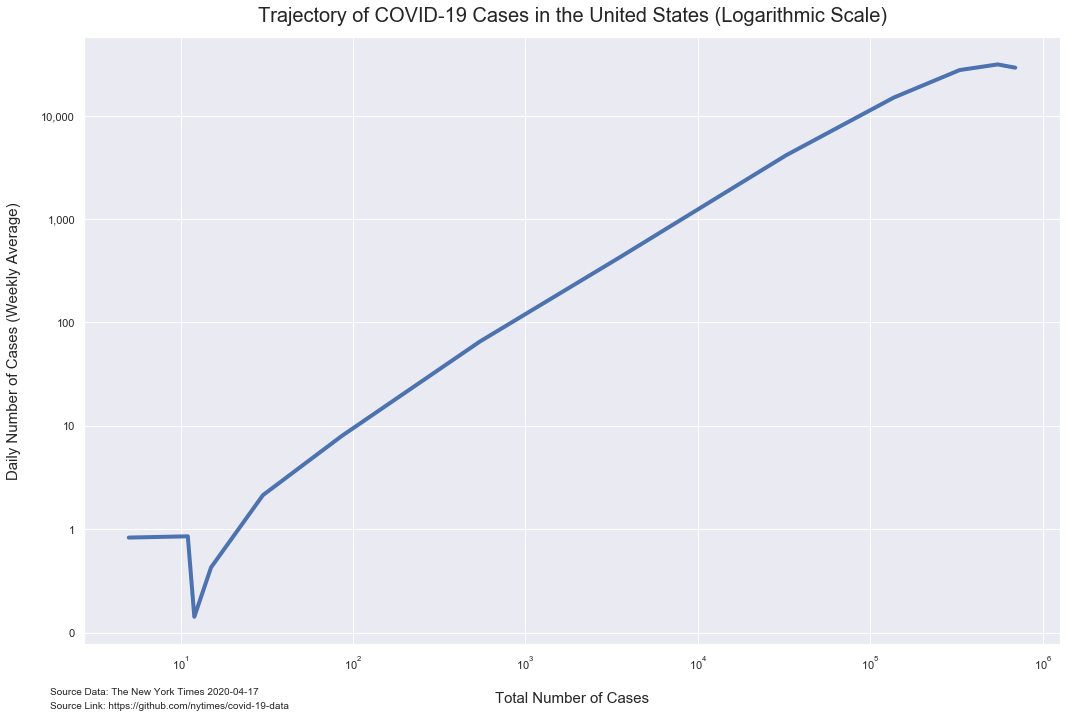

In [140]:
fig, ax1 = plt.subplots(figsize=(15,10))
txt = ('Source Data: The New York Times ' + current_date)
txt2 = ('Source Link: https://github.com/nytimes/covid-19-data')

sns.lineplot(x="cases", y="daily_cases", data=g_weekly, linewidth=4)
ax1.set_yscale('log')
ax1.set_xscale('log')

ax1.xaxis.grid(True, which="major")
ax1.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

ax1.xaxis.labelpad = 20
ax1.yaxis.labelpad = 20

ax1.set_xlabel('Total Number of Cases', fontsize=15)
ax1.set_ylabel('Daily Number of Cases (Weekly Average)', fontsize=15)
plt.title('Trajectory of COVID-19 Cases in the United States (Logarithmic Scale)', 
          pad = 15, fontsize=20)
plt.figtext(0.05, 0.03, txt, wrap=True, horizontalalignment='left', fontsize=10)
plt.figtext(0.05, 0.01, txt2, wrap=True, horizontalalignment='left', fontsize=10)

plt.tight_layout()
plt.savefig('figures/usa-counties-trajectory-weekly-plot')

# Bar Chart

In [141]:
covid_19_counties_data

date      county       state     fips  cases  deaths  \
0     2020-01-21   Snohomish  Washington  53061.0      1       0   
1     2020-01-22   Snohomish  Washington  53061.0      1       0   
2     2020-01-23   Snohomish  Washington  53061.0      1       0   
3     2020-01-24        Cook    Illinois  17031.0      1       0   
4     2020-01-24   Snohomish  Washington  53061.0      1       0   
...          ...         ...         ...      ...    ...     ...   
67451 2020-04-17    Sublette     Wyoming  56035.0      1       0   
67452 2020-04-17  Sweetwater     Wyoming  56037.0     10       0   
67453 2020-04-17       Teton     Wyoming  56039.0     61       0   
67454 2020-04-17       Uinta     Wyoming  56041.0      6       0   
67455 2020-04-17    Washakie     Wyoming  56043.0      4       0   

                 county_name  
0      Snohomish, Washington  
1      Snohomish, Washington  
2      Snohomish, Washington  
3             Cook, Illinois  
4      Snohomish, Washington  
...                      ...  
67451      Sublette, Wyoming  
67452    Sweetwater, Wyoming  
67453         Teton, Wyoming  
67454         Uinta, Wyoming  
67455      Washakie, Wyoming  

[66662 rows x 7 columns]

In [142]:
# dropping ALL duplicate values 
county_current_cases = covid_19_counties_data.sort_values(by = 'date', 
                    ascending=False).drop_duplicates(
                    subset ="county_name", keep = 'first')

In [143]:
county_current_cases.head()

date    county     state     fips  cases  deaths  \
67455 2020-04-17  Washakie   Wyoming  56043.0      4       0   
65619 2020-04-17     Clark  Kentucky  21049.0     18       0   
65627 2020-04-17     Floyd  Kentucky  21071.0      4       0   
65626 2020-04-17   Fleming  Kentucky  21069.0      2       0   
65625 2020-04-17   Fayette  Kentucky  21067.0    214       7   

             county_name  
67455  Washakie, Wyoming  
65619    Clark, Kentucky  
65627    Floyd, Kentucky  
65626  Fleming, Kentucky  
65625  Fayette, Kentucky

In [144]:
county_current_cases.county_name.value_counts()

Dallas, Arkansas            1
Laurel, Kentucky            1
Alpine, California          1
Fillmore, Minnesota         1
Pike, Indiana               1
                           ..
Carteret, North Carolina    1
Jefferson, New York         1
Monroe, Indiana             1
York, South Carolina        1
Cochise, Arizona            1
Name: county_name, Length: 2734, dtype: int64

In [145]:
county_current_cases.loc[county_current_cases.county == 'New York City']

date         county     state  fips   cases  deaths  \
66330 2020-04-17  New York City  New York   NaN  127352    8632   

                   county_name  
66330  New York City, New York

In [146]:
bar = county_current_cases.sort_values(by = 'cases', 
                    ascending=False)
bar = bar[:20]

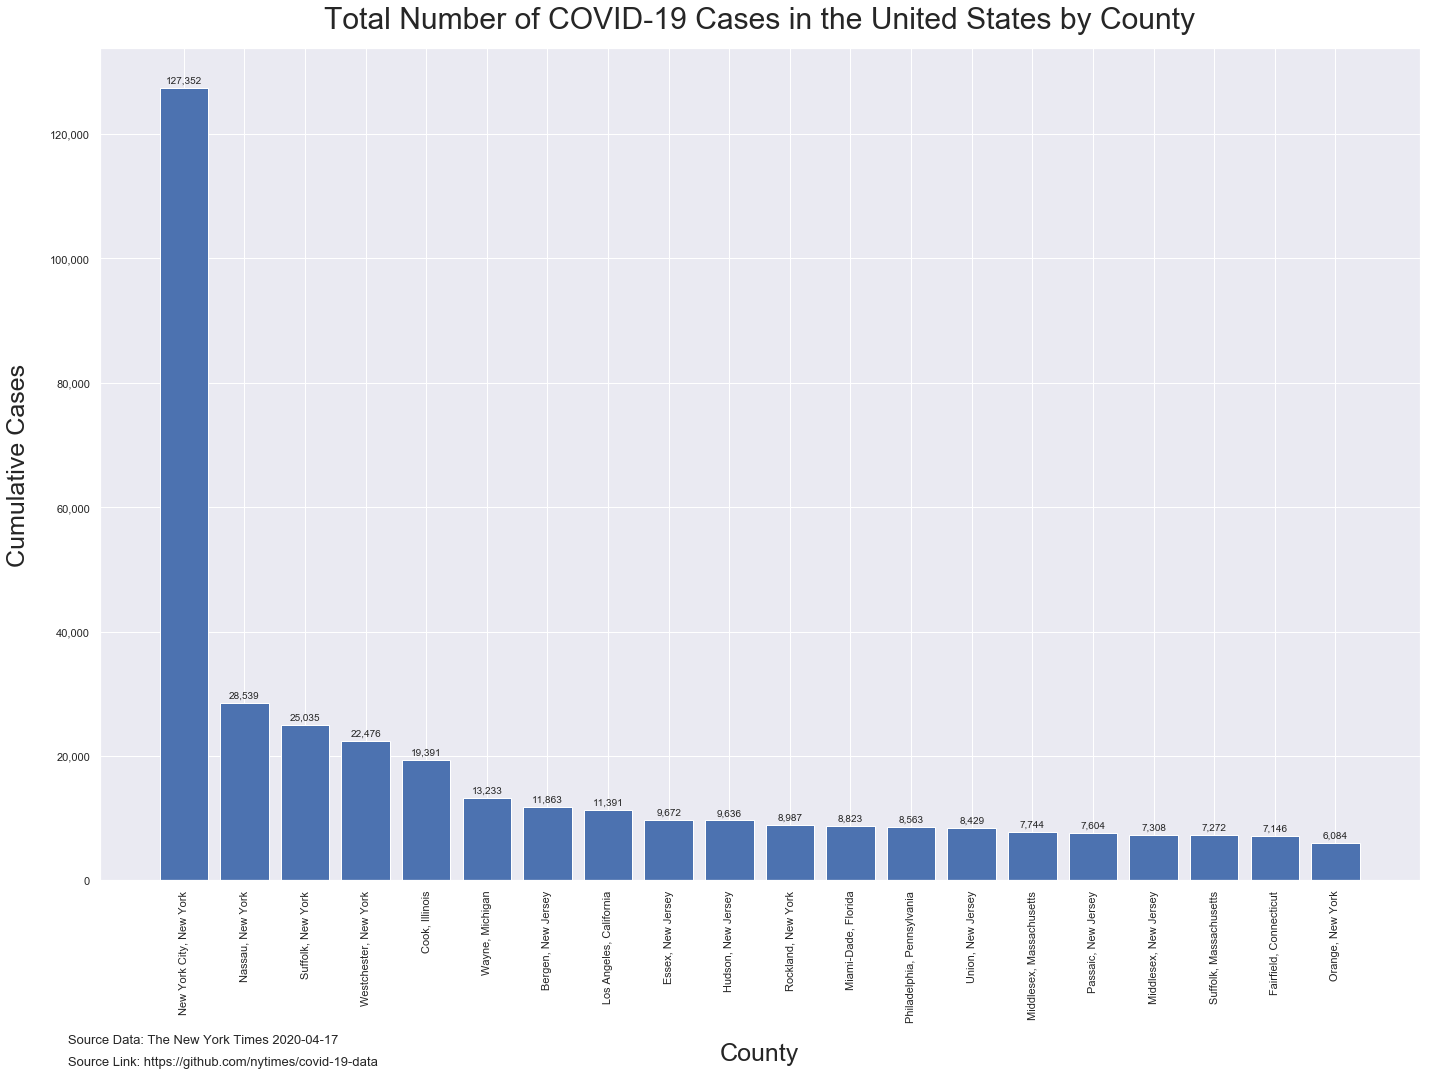

In [147]:
bar = bar.sort_values(by = 'cases', 
                    ascending=False)

bar.set_index('county_name', drop=False, inplace=True)

plt.subplots(figsize=(20,15))
ax = plt.subplot()

label = ax.bar(bar.index, bar.cases)
plt.xlabel("County", labelpad=14, fontsize=25)
plt.xticks(rotation=90)
plt.ylabel("Cumulative Cases", labelpad=14, fontsize=25)
ax.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax.xaxis.labelpad = 20
ax.yaxis.labelpad = 20

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{:,}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(label)

txt = ('Source Data: The New York Times ' + current_date)
txt2 = ('Source Link: https://github.com/nytimes/covid-19-data')
plt.figtext(0.05, 0.03, txt, wrap=True, horizontalalignment='left', fontsize=13)
plt.figtext(0.05, 0.01, txt2, wrap=True, horizontalalignment='left', fontsize=13)

plt.title("Total Number of COVID-19 Cases in the United States by County", pad=20, fontsize=30)
plt.tight_layout()
plt.savefig('figures/counties-bar')

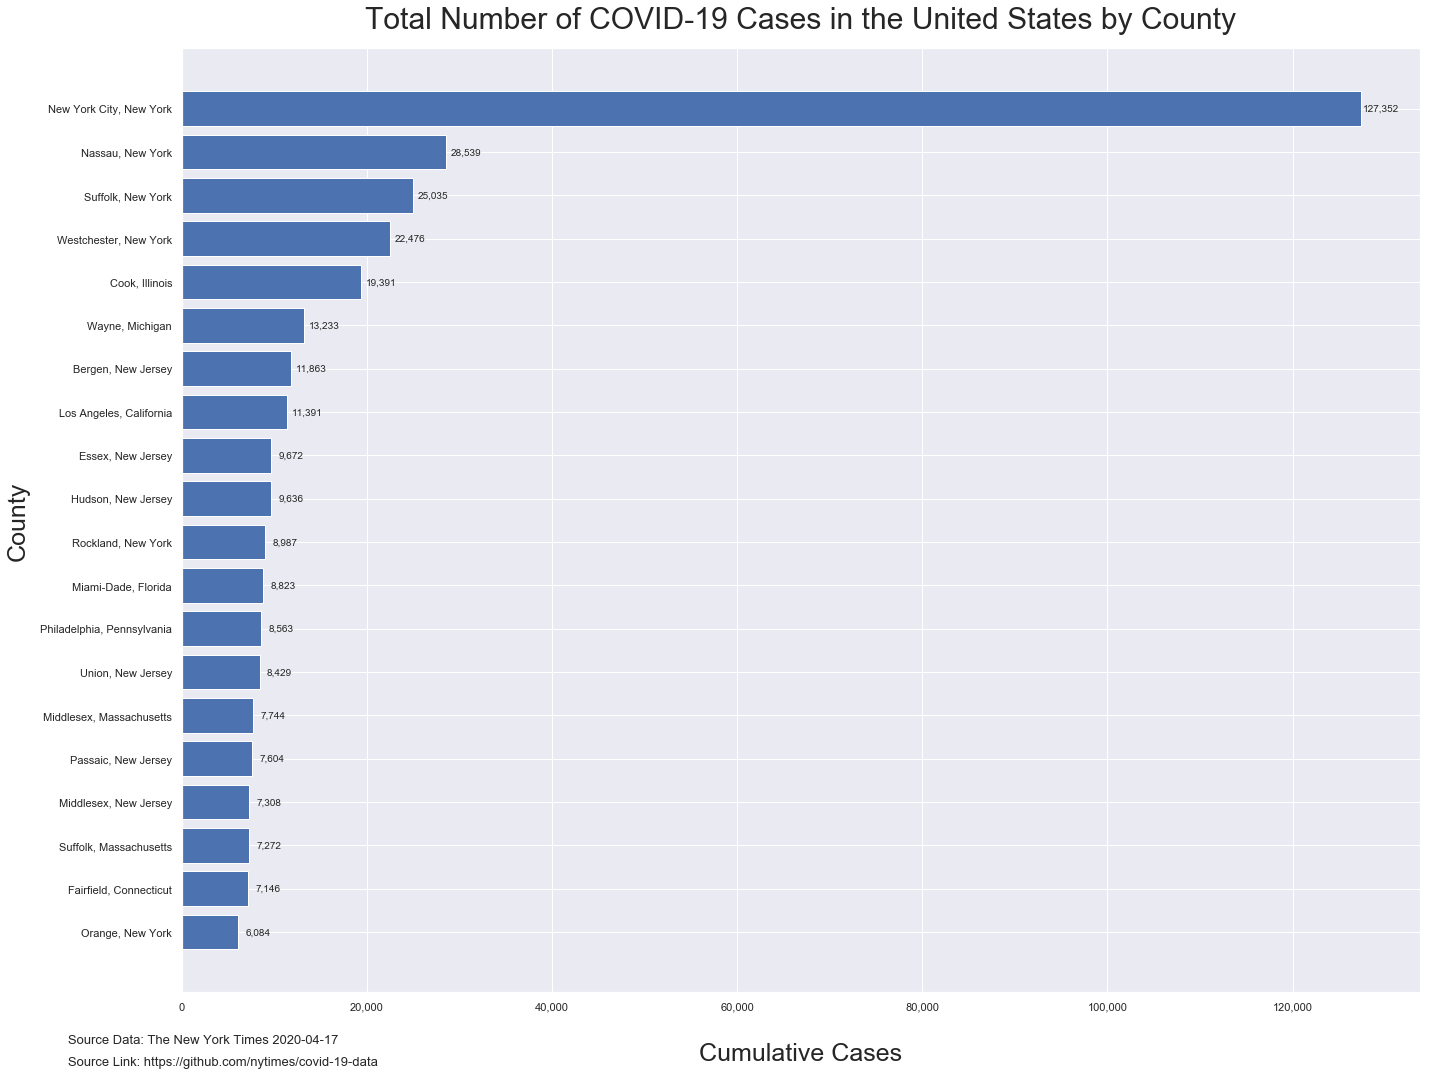

In [148]:
bar = bar.sort_values(by = 'cases', 
                    ascending=True)

bar.set_index('county_name', drop=False, inplace=True)

plt.subplots(figsize=(20,15))
ax = plt.subplot()

label_1 = ax.barh(bar.index, bar.cases)
plt.xlabel("Cumulative Cases", labelpad=14, fontsize=25)
ax.get_xaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.ylabel("County", labelpad=14, fontsize=25)
ax.xaxis.labelpad = 30
ax.yaxis.labelpad = 10

def autolabel_1(rects):
    for rect in rects:
        width = rect.get_width()
        yloc = rect.get_y() + rect.get_height() / 2
        ax.annotate('{:,}'.format(width), 
                    xy=(width, yloc), 
                    xytext=(20, 0),
                    textcoords="offset points",
                    ha='center', va='center')
                
autolabel_1(label_1)

txt = ('Source Data: The New York Times ' + current_date)
txt2 = ('Source Link: https://github.com/nytimes/covid-19-data')
plt.figtext(0.05, 0.03, txt, wrap=True, horizontalalignment='left', fontsize=13)
plt.figtext(0.05, 0.01, txt2, wrap=True, horizontalalignment='left', fontsize=13)

plt.title("Total Number of COVID-19 Cases in the United States by County", pad=20, fontsize=30)
plt.tight_layout()
plt.savefig('figures/counties-barh')

In [149]:
covid_19_counties_data.to_csv('data/us-counties-raw-data.csv', index=False)
g.to_csv('data/us-counties-grouped-day.csv')
bar.to_csv('data/us-counties-grouped-bar.csv')